### Use Python XGBoost and Optuna hyper parameter tuning to build model and deploy with KNIME Python nodes


<img src="../KNIME_loves_xgboost_optuna.png" width="600">


##### KNIME workflow
https://hub.knime.com/-/spaces/-/latest/~GABT_OgeoWxWJW9P/


##### MEDIUM Blog: Hyperparameter optimization for LightGBM — wrapped in KNIME nodes

https://medium.com/p/ddb7ae1d7e2

###### Optuna

https://optuna.readthedocs.io/en/stable/index.html

###### additional links and texts

https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html#for-better-accuracy

https://stackoverflow.com/questions/67080149/xgboost-error-when-categorical-type-is-supplied-dmatrix-parameter-enable-cat


https://towardsdatascience.com/how-to-beat-the-heck-out-of-xgboost-with-lightgbm-comprehensive-tutorial-5eba52195997

https://towardsdatascience.com/kagglers-guide-to-lightgbm-hyperparameter-tuning-with-optuna-in-2021-ed048d9838b5


https://towardsdatascience.com/a-conceptual-explanation-of-bayesian-model-based-hyperparameter-optimization-for-machine-learning-b8172278050f

some parameters have been discussed with ChatGPT ....

In [1]:
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import json
import pickle
import logging

In [2]:
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, auc, average_precision_score, precision_recall_curve

import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances
import matplotlib.pyplot as plt
import plotly
import matplotlib
import kaleido

In [3]:
# http://strftime.org'
import time
var_timestamp_day = "{}".format(time.strftime("%Y%m%d"))
# flow_variables['var_timestamp_day'] = var_timestamp_day
print("var_timestamp_day: ", var_timestamp_day)

var_timestamp_time = "{}h".format(time.strftime("%H%M"))
# flow_variables['var_timestamp_time'] = var_timestamp_time
print("var_timestamp_time: ", var_timestamp_time)

# _edit: if you want to have another model name
var_model_name = "XGBoost_Optuna_Classification"
# flow_variables['var_model_name'] = var_model_name

var_model_name_full = var_model_name + "_" + var_timestamp_day  + "_" + var_timestamp_time + "_jupyter"
# flow_variables['var_model_name_full'] = var_model_name_full
print("var_model_name_full: ", var_model_name_full)

# if you do not want to store the files in the working directory
var_path_data = "../"
var_path_model = "../model/"

var_timestamp_day:  20240229
var_timestamp_time:  1512h
var_model_name_full:  XGBoost_Optuna_Classification_20240229_1512h_jupyter


The data used has beed adapted from:

**Census Income Data Set**

Abstract: Predict whether income exceeds $50K/yr based on census data. Also known as "Adult" dataset.

Extract and prepare the Census Income Files for usage in KNIME

https://archive.ics.uci.edu/ml/datasets/census+income

In [4]:
data      = pq.read_table(var_path_data + "train.parquet").to_pandas()
data_test = pq.read_table(var_path_data + "test.parquet").to_pandas()

In [5]:
data = data.reset_index(drop=True)

In [6]:
data_test = data_test.reset_index(drop=True)

In [7]:
excluded_features = ['row_id']
label = ['Target']
# features = [feat for feat in data.columns if feat not in excluded_features and not feat==label]
features = [feat for feat in data.columns if feat not in excluded_features and feat not in label]

num_cols = data[features].select_dtypes(include='number').columns.tolist()
cat_cols = data[features].select_dtypes(exclude='number').columns.tolist()

rest_cols = [feat for feat in data.columns if feat not in cat_cols]

print(f'''{"data shape:":20} {data.shape}
{"data[features] shape:":20} {data[features].shape}
categorical columns: {cat_cols}
numerical columns: {num_cols}
feature columns: {features}
rest columns: {rest_cols}''')

# THX David Gutmann 

data shape:          (34189, 16)
data[features] shape: (34189, 14)
categorical columns: ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
numerical columns: ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
feature columns: ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
rest columns: ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'Target', 'row_id']


In [8]:
print(data.dtypes)

age                int32
workclass         object
fnlwgt             int32
education         object
education-num      int32
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int32
capital-loss       int32
hours-per-week     int32
native-country    object
Target            object
row_id            object
dtype: object


In [9]:
data[cat_cols] = data[cat_cols].astype('category')

In [10]:
data[label] = data[label].astype('int32')

In [11]:
print(data.dtypes)

age                  int32
workclass         category
fnlwgt               int32
education         category
education-num        int32
marital-status    category
occupation        category
relationship      category
race              category
sex               category
capital-gain         int32
capital-loss         int32
hours-per-week       int32
native-country    category
Target               int32
row_id              object
dtype: object


In [12]:
# split training data into X and y
X = data[features]
y = data[label]

In [13]:
X.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
3,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States
4,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica


In [14]:
# split data into train and test sets
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

In [15]:
D_train = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
D_test = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)

In [16]:
# y_train = np.ravel(y_train)
# y_test = np.ravel(y_test)

In [17]:
# number of iterations
var_n_boost_round = 200

def objective(trial):
    param = {
        'eta': trial.suggest_float('eta', 0.01, 0.3),                  # Step size shrinkage used in update to prevents overfitting.
        'max_depth': trial.suggest_int('max_depth', 6, 15),                 # Maximum depth of a tree. Larger values can lead to overfitting.
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),           # Subsample ratio of the training instances. Lower values can prevent overfitting.
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),  # Subsample ratio of columns when constructing each tree. Lower values can prevent overfitting.
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0),               # Minimum loss reduction required to make a further partition on a leaf node of the tree.
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0),               # L1 regularization term on weights. Can help with sparsity of the model.
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0),             # L2 regularization term on weights. Can help with overfitting.
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),     # Minimum sum of instance weight (hessian) needed in a child. Can help with overfitting.
        'max_delta_step': trial.suggest_int('max_delta_step', 0, 10),         # Maximum delta step we allow each tree's weight estimation to be. Can help with convergence speed.
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0.1, 10),  # Control the balance of positive and negative weights, for imbalanced datasets.
        'tree_method': trial.suggest_categorical('tree_method', ['auto', 'exact', 'approx', 'hist']),  # Algorithm used to construct trees. , 'gpu_hist' excluded
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),  # Step size shrinkage used in update to prevents overfitting.
        'objective': 'binary:logistic',                                      # Objective function to optimize. In this case, binary logistic regression.
        'eval_metric': 'aucpr' ,                                            # Metric to evaluate the model during training. In this case, AUC-PR.
        'min_split_loss': trial.suggest_float('min_split_loss', 1e-8, 1.0), # minimum loss reduction required to make a split in the tree. It can be used to control the complexity of the tree
        'max_bin': trial.suggest_int('max_bin', 64, 512) , # maximum number of bins to use for continuous features. 
        # 'early_stopping_rounds': trial.suggest_int('early_stopping_rounds', 25, 50),
        # 'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear']),
        # 'sample_type': trial.suggest_categorical('sample_type', ['uniform', 'weighted', 'weighted_unique']),
        # 'normalize_type': trial.suggest_categorical('normalize_type', ['tree', 'forest', 'none'])
        'seed': 42,  # The random seed.
        'n_jobs': -1  # Number of CPU threads to use for parallel execution, -1 means use all available CPU threads
    }

    # Train model with the given hyperparameters
    model = xgb.train(param, D_train, num_boost_round=var_n_boost_round, evals=[(D_test, 'val')], early_stopping_rounds=25, verbose_eval=50)
    
    # Predict and calculate AUCPR score on validation set
    y_val_pred = model.predict(D_test)
    score = average_precision_score(y_test, y_val_pred)

    return score

In [18]:
var_n_trials = var_n_boost_round

# Create Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=var_n_trials)

# Get the best hyperparameters and best AUCPR score

best_params = study.best_params
best_score = study.best_value


[I 2024-02-29 15:13:23,815] A new study created in memory with name: no-name-834eedad-c38a-407e-9c99-b5bec234a910


[0]	val-aucpr:0.60474
[50]	val-aucpr:0.80145
[100]	val-aucpr:0.82289
[150]	val-aucpr:0.82894
[199]	val-aucpr:0.83099


[I 2024-02-29 15:13:24,545] Trial 0 finished with value: 0.831017073532904 and parameters: {'eta': 0.023069754946381284, 'max_depth': 6, 'subsample': 0.7592045719244712, 'colsample_bytree': 0.7800834562678168, 'gamma': 0.3238820995058471, 'alpha': 0.27268483071284777, 'lambda': 0.4061243110291085, 'min_child_weight': 10, 'max_delta_step': 1, 'scale_pos_weight': 2.33348549060285, 'tree_method': 'auto', 'learning_rate': 0.046001803327489474, 'min_split_loss': 0.10934277572118818, 'max_bin': 151}. Best is trial 0 with value: 0.831017073532904.


[0]	val-aucpr:0.54194
[50]	val-aucpr:0.79380
[100]	val-aucpr:0.81642
[150]	val-aucpr:0.82590
[184]	val-aucpr:0.82557


[I 2024-02-29 15:13:25,506] Trial 1 finished with value: 0.8255994064863199 and parameters: {'eta': 0.23614453047043454, 'max_depth': 11, 'subsample': 0.48047777713039114, 'colsample_bytree': 0.3352655959369568, 'gamma': 0.04772929408532009, 'alpha': 0.9027368689049532, 'lambda': 0.049244388770528856, 'min_child_weight': 4, 'max_delta_step': 2, 'scale_pos_weight': 2.803581222177315, 'tree_method': 'auto', 'learning_rate': 0.06974978727532533, 'min_split_loss': 0.4729258655280547, 'max_bin': 123}. Best is trial 0 with value: 0.831017073532904.


[0]	val-aucpr:0.47483
[50]	val-aucpr:0.80290
[100]	val-aucpr:0.81567
[143]	val-aucpr:0.81862


[I 2024-02-29 15:13:26,236] Trial 2 finished with value: 0.81865823526983 and parameters: {'eta': 0.03486437121959417, 'max_depth': 14, 'subsample': 0.33226676209525063, 'colsample_bytree': 0.2494798086684184, 'gamma': 0.10839208685484192, 'alpha': 0.4007207292014859, 'lambda': 0.012219056078125646, 'min_child_weight': 5, 'max_delta_step': 4, 'scale_pos_weight': 1.1450625863494939, 'tree_method': 'auto', 'learning_rate': 0.1242228544516716, 'min_split_loss': 0.20442468161366398, 'max_bin': 345}. Best is trial 0 with value: 0.831017073532904.


[0]	val-aucpr:0.47346
[50]	val-aucpr:0.78394
[100]	val-aucpr:0.79854
[150]	val-aucpr:0.80264
[154]	val-aucpr:0.80232


[I 2024-02-29 15:13:27,034] Trial 3 finished with value: 0.8023549363563605 and parameters: {'eta': 0.07276261519530396, 'max_depth': 14, 'subsample': 0.2799999508472547, 'colsample_bytree': 0.2293082088923786, 'gamma': 0.5707650988770745, 'alpha': 0.6436320649984049, 'lambda': 0.2528465673281649, 'min_child_weight': 9, 'max_delta_step': 8, 'scale_pos_weight': 9.839545646429789, 'tree_method': 'auto', 'learning_rate': 0.16431264135605625, 'min_split_loss': 0.5991257215593524, 'max_bin': 154}. Best is trial 0 with value: 0.831017073532904.


[0]	val-aucpr:0.63534
[50]	val-aucpr:0.80761
[100]	val-aucpr:0.82183
[150]	val-aucpr:0.82830
[199]	val-aucpr:0.83220


[I 2024-02-29 15:13:28,595] Trial 4 finished with value: 0.8322337261360693 and parameters: {'eta': 0.043509740861257196, 'max_depth': 11, 'subsample': 0.8944586455581021, 'colsample_bytree': 0.22981248325263204, 'gamma': 0.7387207394125922, 'alpha': 0.7106889120102948, 'lambda': 0.9541740592244279, 'min_child_weight': 2, 'max_delta_step': 8, 'scale_pos_weight': 2.538426418222494, 'tree_method': 'exact', 'learning_rate': 0.06073044498327905, 'min_split_loss': 0.11080525639875195, 'max_bin': 94}. Best is trial 4 with value: 0.8322337261360693.


[0]	val-aucpr:0.53588
[50]	val-aucpr:0.80288
[76]	val-aucpr:0.80266


[I 2024-02-29 15:13:29,079] Trial 5 finished with value: 0.8026996484791138 and parameters: {'eta': 0.2923693265184453, 'max_depth': 14, 'subsample': 0.15039910314533073, 'colsample_bytree': 0.538770480457095, 'gamma': 0.8683312805595563, 'alpha': 0.5995690885204837, 'lambda': 0.8706244778109676, 'min_child_weight': 4, 'max_delta_step': 6, 'scale_pos_weight': 5.645385594703202, 'tree_method': 'auto', 'learning_rate': 0.09303671985422363, 'min_split_loss': 0.4238336107487962, 'max_bin': 298}. Best is trial 4 with value: 0.8322337261360693.


[0]	val-aucpr:0.33757
[50]	val-aucpr:0.76433
[100]	val-aucpr:0.78906
[123]	val-aucpr:0.78923


[I 2024-02-29 15:13:29,525] Trial 6 finished with value: 0.7892756574914198 and parameters: {'eta': 0.298495656879317, 'max_depth': 6, 'subsample': 0.7432392217438533, 'colsample_bytree': 0.13836171041820597, 'gamma': 0.13435708818352782, 'alpha': 0.6868588488486272, 'lambda': 0.8779944814339511, 'min_child_weight': 2, 'max_delta_step': 1, 'scale_pos_weight': 9.033242640325902, 'tree_method': 'exact', 'learning_rate': 0.08905222905865684, 'min_split_loss': 0.8082532730451438, 'max_bin': 480}. Best is trial 4 with value: 0.8322337261360693.


[0]	val-aucpr:0.72425
[50]	val-aucpr:0.82180
[100]	val-aucpr:0.82447
[150]	val-aucpr:0.82496
[170]	val-aucpr:0.82489


[I 2024-02-29 15:13:30,171] Trial 7 finished with value: 0.8247691170466867 and parameters: {'eta': 0.015783665339972008, 'max_depth': 12, 'subsample': 0.7368372464428482, 'colsample_bytree': 0.7697704376466048, 'gamma': 0.1746878539092748, 'alpha': 0.5728030541520812, 'lambda': 0.7652289279369038, 'min_child_weight': 7, 'max_delta_step': 7, 'scale_pos_weight': 0.2582939068130343, 'tree_method': 'auto', 'learning_rate': 0.11560507760480655, 'min_split_loss': 0.8314638456088063, 'max_bin': 113}. Best is trial 4 with value: 0.8322337261360693.


[0]	val-aucpr:0.31558
[50]	val-aucpr:0.77488
[100]	val-aucpr:0.79264
[150]	val-aucpr:0.81077
[190]	val-aucpr:0.81191


[I 2024-02-29 15:13:31,150] Trial 8 finished with value: 0.8119547238122686 and parameters: {'eta': 0.2505010383497693, 'max_depth': 14, 'subsample': 0.7090764669721374, 'colsample_bytree': 0.1971297772578719, 'gamma': 0.012406211412717166, 'alpha': 0.6077191923498884, 'lambda': 0.8166234982686102, 'min_child_weight': 1, 'max_delta_step': 9, 'scale_pos_weight': 9.169517908547494, 'tree_method': 'hist', 'learning_rate': 0.09898750245244359, 'min_split_loss': 0.0935167415536562, 'max_bin': 509}. Best is trial 4 with value: 0.8322337261360693.


[0]	val-aucpr:0.47117
[50]	val-aucpr:0.77867
[100]	val-aucpr:0.79812
[150]	val-aucpr:0.81595
[199]	val-aucpr:0.82227


[I 2024-02-29 15:13:31,948] Trial 9 finished with value: 0.8223017171115117 and parameters: {'eta': 0.24290467677412403, 'max_depth': 7, 'subsample': 0.7963945001759997, 'colsample_bytree': 0.27381496488130547, 'gamma': 0.11206347669023782, 'alpha': 0.2936069451674406, 'lambda': 0.9801396246641164, 'min_child_weight': 1, 'max_delta_step': 5, 'scale_pos_weight': 8.077817173713175, 'tree_method': 'auto', 'learning_rate': 0.050889608146152294, 'min_split_loss': 0.3239779633142454, 'max_bin': 318}. Best is trial 4 with value: 0.8322337261360693.


[0]	val-aucpr:0.67317
[44]	val-aucpr:0.79672


[I 2024-02-29 15:13:32,354] Trial 10 finished with value: 0.7967463211186583 and parameters: {'eta': 0.14081102296563217, 'max_depth': 9, 'subsample': 0.9814745347914342, 'colsample_bytree': 0.4834234500510296, 'gamma': 0.9980139477429124, 'alpha': 0.01274783475790181, 'lambda': 0.6189049030500873, 'min_child_weight': 3, 'max_delta_step': 10, 'scale_pos_weight': 4.234813447482977, 'tree_method': 'exact', 'learning_rate': 0.01762178902493402, 'min_split_loss': 0.00034382613898938097, 'max_bin': 244}. Best is trial 4 with value: 0.8322337261360693.


[0]	val-aucpr:0.78581
[50]	val-aucpr:0.81483
[100]	val-aucpr:0.82408
[150]	val-aucpr:0.82918
[199]	val-aucpr:0.83117


[I 2024-02-29 15:13:33,724] Trial 11 finished with value: 0.8312011816060383 and parameters: {'eta': 0.0973807435062703, 'max_depth': 9, 'subsample': 0.992600640423146, 'colsample_bytree': 0.9460678337208057, 'gamma': 0.4912606073795002, 'alpha': 0.1939314311114554, 'lambda': 0.4094385123947706, 'min_child_weight': 10, 'max_delta_step': 3, 'scale_pos_weight': 2.7876520870331074, 'tree_method': 'approx', 'learning_rate': 0.03002268511959418, 'min_split_loss': 0.20158851108813775, 'max_bin': 76}. Best is trial 4 with value: 0.8322337261360693.


[0]	val-aucpr:0.78579
[50]	val-aucpr:0.80720
[100]	val-aucpr:0.81358
[150]	val-aucpr:0.81819
[199]	val-aucpr:0.82100


[I 2024-02-29 15:13:35,207] Trial 12 finished with value: 0.8209803939440862 and parameters: {'eta': 0.10041148226485051, 'max_depth': 9, 'subsample': 0.9955862422537299, 'colsample_bytree': 0.9948700433052505, 'gamma': 0.6201608792284546, 'alpha': 0.022613228230558335, 'lambda': 0.5026725598495694, 'min_child_weight': 7, 'max_delta_step': 4, 'scale_pos_weight': 4.785541194295433, 'tree_method': 'approx', 'learning_rate': 0.010484116964452634, 'min_split_loss': 0.2710380077301322, 'max_bin': 78}. Best is trial 4 with value: 0.8322337261360693.


[0]	val-aucpr:0.77667
[50]	val-aucpr:0.81818
[100]	val-aucpr:0.82941
[150]	val-aucpr:0.83264
[199]	val-aucpr:0.83320


[I 2024-02-29 15:13:36,613] Trial 13 finished with value: 0.833231138697567 and parameters: {'eta': 0.1022354929437301, 'max_depth': 9, 'subsample': 0.8784774792555996, 'colsample_bytree': 0.7232782864966778, 'gamma': 0.7122083562845074, 'alpha': 0.8547682419302772, 'lambda': 0.3009154301581485, 'min_child_weight': 7, 'max_delta_step': 3, 'scale_pos_weight': 2.996007481825913, 'tree_method': 'approx', 'learning_rate': 0.043045598968211425, 'min_split_loss': 0.6157234498468708, 'max_bin': 190}. Best is trial 13 with value: 0.833231138697567.


[0]	val-aucpr:0.77404
[50]	val-aucpr:0.81344
[52]	val-aucpr:0.81267


[I 2024-02-29 15:13:37,299] Trial 14 finished with value: 0.812703730043775 and parameters: {'eta': 0.1626483376198577, 'max_depth': 12, 'subsample': 0.5602156619742383, 'colsample_bytree': 0.7165188670999483, 'gamma': 0.7222416988416062, 'alpha': 0.898636017748867, 'lambda': 0.20011028718758905, 'min_child_weight': 7, 'max_delta_step': 7, 'scale_pos_weight': 6.267079026509826, 'tree_method': 'exact', 'learning_rate': 0.1998215739913563, 'min_split_loss': 0.6602029332898425, 'max_bin': 221}. Best is trial 13 with value: 0.833231138697567.


[0]	val-aucpr:0.67412
[50]	val-aucpr:0.80838
[100]	val-aucpr:0.82309
[150]	val-aucpr:0.83114
[174]	val-aucpr:0.83104


[I 2024-02-29 15:13:38,616] Trial 15 finished with value: 0.8309954411769771 and parameters: {'eta': 0.16307487276021537, 'max_depth': 10, 'subsample': 0.8728886717733542, 'colsample_bytree': 0.4211576045076009, 'gamma': 0.7723896858334313, 'alpha': 0.7655553792932829, 'lambda': 0.6511692200465317, 'min_child_weight': 6, 'max_delta_step': 10, 'scale_pos_weight': 3.6684260388665257, 'tree_method': 'approx', 'learning_rate': 0.0673986035007863, 'min_split_loss': 0.6607502474228565, 'max_bin': 212}. Best is trial 13 with value: 0.833231138697567.


[0]	val-aucpr:0.70241
[50]	val-aucpr:0.81371
[100]	val-aucpr:0.82520
[150]	val-aucpr:0.82804
[170]	val-aucpr:0.82772


[I 2024-02-29 15:13:39,594] Trial 16 finished with value: 0.8277498019093628 and parameters: {'eta': 0.06969288739576916, 'max_depth': 12, 'subsample': 0.6112370820797202, 'colsample_bytree': 0.6496937732873336, 'gamma': 0.4155897880604117, 'alpha': 0.9937750786209456, 'lambda': 0.2743225216394475, 'min_child_weight': 8, 'max_delta_step': 0, 'scale_pos_weight': 1.4888818258149434, 'tree_method': 'hist', 'learning_rate': 0.0404567326916112, 'min_split_loss': 0.9871173327106832, 'max_bin': 402}. Best is trial 13 with value: 0.833231138697567.


[0]	val-aucpr:0.77061
[50]	val-aucpr:0.82159
[100]	val-aucpr:0.83035
[145]	val-aucpr:0.83194


[I 2024-02-29 15:13:40,571] Trial 17 finished with value: 0.8321061631717726 and parameters: {'eta': 0.12404102137965636, 'max_depth': 8, 'subsample': 0.8704278818014681, 'colsample_bytree': 0.6208935164768475, 'gamma': 0.8213913050488919, 'alpha': 0.7654359061238056, 'lambda': 0.5716852558130042, 'min_child_weight': 5, 'max_delta_step': 5, 'scale_pos_weight': 6.667734871811108, 'tree_method': 'approx', 'learning_rate': 0.07328356179241108, 'min_split_loss': 0.37707175300856094, 'max_bin': 171}. Best is trial 13 with value: 0.833231138697567.


[0]	val-aucpr:0.67013
[50]	val-aucpr:0.82634
[78]	val-aucpr:0.82572


[I 2024-02-29 15:13:41,320] Trial 18 finished with value: 0.8263055795106836 and parameters: {'eta': 0.20050381697027558, 'max_depth': 11, 'subsample': 0.876783074028535, 'colsample_bytree': 0.3870631249525299, 'gamma': 0.6711324438364786, 'alpha': 0.835193941964542, 'lambda': 0.36781455800814566, 'min_child_weight': 6, 'max_delta_step': 3, 'scale_pos_weight': 3.4804872206763617, 'tree_method': 'exact', 'learning_rate': 0.13491353582926785, 'min_split_loss': 0.550561431839977, 'max_bin': 245}. Best is trial 13 with value: 0.833231138697567.


[0]	val-aucpr:0.78951
[50]	val-aucpr:0.82616
[100]	val-aucpr:0.82931
[129]	val-aucpr:0.82828


[I 2024-02-29 15:13:42,332] Trial 19 finished with value: 0.8283546489698723 and parameters: {'eta': 0.053224367393033496, 'max_depth': 10, 'subsample': 0.6361461343255279, 'colsample_bytree': 0.8621729724935732, 'gamma': 0.9410352372836708, 'alpha': 0.4587002926835377, 'lambda': 0.16503341655110487, 'min_child_weight': 3, 'max_delta_step': 8, 'scale_pos_weight': 1.810114148041803, 'tree_method': 'approx', 'learning_rate': 0.06143514166753338, 'min_split_loss': 0.8109273096158045, 'max_bin': 190}. Best is trial 13 with value: 0.833231138697567.


[0]	val-aucpr:0.74072
[50]	val-aucpr:0.80863
[100]	val-aucpr:0.81208
[150]	val-aucpr:0.81507
[199]	val-aucpr:0.81657


[I 2024-02-29 15:13:43,791] Trial 20 finished with value: 0.8166043284939469 and parameters: {'eta': 0.09985771052733898, 'max_depth': 8, 'subsample': 0.5106850424054368, 'colsample_bytree': 0.5866376783630955, 'gamma': 0.5255662314496578, 'alpha': 0.744360633318799, 'lambda': 0.7004020713658581, 'min_child_weight': 8, 'max_delta_step': 6, 'scale_pos_weight': 0.3624797176570733, 'tree_method': 'exact', 'learning_rate': 0.02833289430893448, 'min_split_loss': 0.674477526306725, 'max_bin': 67}. Best is trial 13 with value: 0.833231138697567.


[0]	val-aucpr:0.77148
[50]	val-aucpr:0.82007
[100]	val-aucpr:0.83070
[150]	val-aucpr:0.83124
[156]	val-aucpr:0.83105


[I 2024-02-29 15:13:44,868] Trial 21 finished with value: 0.8309166485867396 and parameters: {'eta': 0.1295751943091649, 'max_depth': 8, 'subsample': 0.8442142124026961, 'colsample_bytree': 0.5961350499495676, 'gamma': 0.8379369204907138, 'alpha': 0.7837006353101962, 'lambda': 0.5353394901162609, 'min_child_weight': 5, 'max_delta_step': 5, 'scale_pos_weight': 7.305690550289098, 'tree_method': 'approx', 'learning_rate': 0.07347949119685465, 'min_split_loss': 0.3760476156358285, 'max_bin': 170}. Best is trial 13 with value: 0.833231138697567.


[0]	val-aucpr:0.77059
[50]	val-aucpr:0.82381
[100]	val-aucpr:0.83225
[145]	val-aucpr:0.83301


[I 2024-02-29 15:13:45,793] Trial 22 finished with value: 0.8330407942242761 and parameters: {'eta': 0.12838043647035566, 'max_depth': 8, 'subsample': 0.8954360828062329, 'colsample_bytree': 0.7074082511045396, 'gamma': 0.7975121894451872, 'alpha': 0.9135573251695199, 'lambda': 0.9772348973361884, 'min_child_weight': 4, 'max_delta_step': 4, 'scale_pos_weight': 6.3141615192893426, 'tree_method': 'approx', 'learning_rate': 0.0786806774177417, 'min_split_loss': 0.49473919956113815, 'max_bin': 117}. Best is trial 13 with value: 0.833231138697567.


[0]	val-aucpr:0.77646
[50]	val-aucpr:0.82306
[100]	val-aucpr:0.83227
[150]	val-aucpr:0.83377
[173]	val-aucpr:0.83338


[I 2024-02-29 15:13:46,770] Trial 23 finished with value: 0.833402833802611 and parameters: {'eta': 0.06462041547602299, 'max_depth': 7, 'subsample': 0.8983710748586371, 'colsample_bytree': 0.8424130167265208, 'gamma': 0.7038468818602599, 'alpha': 0.9849302224285676, 'lambda': 0.965108750199231, 'min_child_weight': 3, 'max_delta_step': 3, 'scale_pos_weight': 5.210114458277937, 'tree_method': 'approx', 'learning_rate': 0.056644348878169395, 'min_split_loss': 0.4948715795665172, 'max_bin': 107}. Best is trial 23 with value: 0.833402833802611.


[0]	val-aucpr:0.77643
[50]	val-aucpr:0.82717
[100]	val-aucpr:0.83041
[115]	val-aucpr:0.82982


[I 2024-02-29 15:13:47,426] Trial 24 finished with value: 0.8298464758330472 and parameters: {'eta': 0.07700729112299756, 'max_depth': 7, 'subsample': 0.658801792140336, 'colsample_bytree': 0.8558806816281258, 'gamma': 0.6530343926509945, 'alpha': 0.9666898738120316, 'lambda': 0.9857942276568503, 'min_child_weight': 4, 'max_delta_step': 3, 'scale_pos_weight': 5.321849347539826, 'tree_method': 'approx', 'learning_rate': 0.08861987303812459, 'min_split_loss': 0.5214583895115824, 'max_bin': 128}. Best is trial 23 with value: 0.833402833802611.


[0]	val-aucpr:0.75692
[36]	val-aucpr:0.80001


[I 2024-02-29 15:13:47,665] Trial 25 finished with value: 0.7997771939907331 and parameters: {'eta': 0.18588811426407076, 'max_depth': 7, 'subsample': 0.9263727695306025, 'colsample_bytree': 0.6827075607178281, 'gamma': 0.9026112844263714, 'alpha': 0.8701449429722714, 'lambda': 0.8890035776772327, 'min_child_weight': 3, 'max_delta_step': 2, 'scale_pos_weight': 6.253275036376474, 'tree_method': 'approx', 'learning_rate': 0.03425041229678344, 'min_split_loss': 0.7297519458519944, 'max_bin': 261}. Best is trial 23 with value: 0.833402833802611.


[0]	val-aucpr:0.78631
[50]	val-aucpr:0.82251
[100]	val-aucpr:0.83074
[150]	val-aucpr:0.83256
[173]	val-aucpr:0.83155


[I 2024-02-29 15:13:48,703] Trial 26 finished with value: 0.8315726684054994 and parameters: {'eta': 0.12096223742622766, 'max_depth': 8, 'subsample': 0.7931555020398785, 'colsample_bytree': 0.8497036918162927, 'gamma': 0.768421085576028, 'alpha': 0.956211668268331, 'lambda': 0.7493291236528024, 'min_child_weight': 2, 'max_delta_step': 4, 'scale_pos_weight': 4.647172677854748, 'tree_method': 'approx', 'learning_rate': 0.0525544293253713, 'min_split_loss': 0.4630753150112454, 'max_bin': 198}. Best is trial 23 with value: 0.833402833802611.


[0]	val-aucpr:0.74298
[50]	val-aucpr:0.83057
[90]	val-aucpr:0.83196


[I 2024-02-29 15:13:49,173] Trial 27 finished with value: 0.8319920344916658 and parameters: {'eta': 0.09021734653241678, 'max_depth': 6, 'subsample': 0.9287995109413442, 'colsample_bytree': 0.7614974808688781, 'gamma': 0.42546693602339375, 'alpha': 0.8244659368610936, 'lambda': 0.34731165627889354, 'min_child_weight': 6, 'max_delta_step': 2, 'scale_pos_weight': 7.457066441905676, 'tree_method': 'approx', 'learning_rate': 0.13785894007566474, 'min_split_loss': 0.5809075294709706, 'max_bin': 125}. Best is trial 23 with value: 0.833402833802611.


[0]	val-aucpr:0.77717
[50]	val-aucpr:0.82446
[82]	val-aucpr:0.82495


[I 2024-02-29 15:13:49,503] Trial 28 finished with value: 0.8247302998760814 and parameters: {'eta': 0.054134192928614426, 'max_depth': 7, 'subsample': 0.4195563539154154, 'colsample_bytree': 0.9113459962733873, 'gamma': 0.6589198272148966, 'alpha': 0.9302317646607579, 'lambda': 0.13837418164232068, 'min_child_weight': 4, 'max_delta_step': 0, 'scale_pos_weight': 4.054826545203486, 'tree_method': 'hist', 'learning_rate': 0.08430205009829086, 'min_split_loss': 0.9573968018149221, 'max_bin': 102}. Best is trial 23 with value: 0.833402833802611.


[0]	val-aucpr:0.79000
[50]	val-aucpr:0.82946
[83]	val-aucpr:0.82966


[I 2024-02-29 15:13:50,042] Trial 29 finished with value: 0.8296855045134813 and parameters: {'eta': 0.19278100379033902, 'max_depth': 9, 'subsample': 0.7593749070136925, 'colsample_bytree': 0.8041818740041169, 'gamma': 0.27052708199328357, 'alpha': 0.990032862510986, 'lambda': 0.43890878272152145, 'min_child_weight': 8, 'max_delta_step': 3, 'scale_pos_weight': 5.509940182325291, 'tree_method': 'approx', 'learning_rate': 0.11127284455193312, 'min_split_loss': 0.7493786036448896, 'max_bin': 149}. Best is trial 23 with value: 0.833402833802611.


[0]	val-aucpr:0.63565
[50]	val-aucpr:0.80341
[100]	val-aucpr:0.82428
[150]	val-aucpr:0.82982
[199]	val-aucpr:0.83130


[I 2024-02-29 15:13:51,058] Trial 30 finished with value: 0.8313299164679163 and parameters: {'eta': 0.1468674290431528, 'max_depth': 6, 'subsample': 0.8163964048639887, 'colsample_bytree': 0.7188114458234324, 'gamma': 0.5641119475057148, 'alpha': 0.8438575939484214, 'lambda': 0.794625636312265, 'min_child_weight': 3, 'max_delta_step': 1, 'scale_pos_weight': 6.936007576943906, 'tree_method': 'approx', 'learning_rate': 0.04747471653514133, 'min_split_loss': 0.6027002362966811, 'max_bin': 145}. Best is trial 23 with value: 0.833402833802611.


[0]	val-aucpr:0.66764
[43]	val-aucpr:0.81621


[I 2024-02-29 15:13:51,477] Trial 31 finished with value: 0.8173855361490922 and parameters: {'eta': 0.03754036286576718, 'max_depth': 10, 'subsample': 0.9224331736995457, 'colsample_bytree': 0.4783521909785321, 'gamma': 0.7425451633356814, 'alpha': 0.6969758439581909, 'lambda': 0.9302495223749394, 'min_child_weight': 2, 'max_delta_step': 4, 'scale_pos_weight': 2.4050192664188006, 'tree_method': 'exact', 'learning_rate': 0.059798490264214445, 'min_split_loss': 0.09492274390526576, 'max_bin': 91}. Best is trial 23 with value: 0.833402833802611.


[0]	val-aucpr:0.78322
[50]	val-aucpr:0.82543
[100]	val-aucpr:0.83090
[137]	val-aucpr:0.83014


[I 2024-02-29 15:13:52,481] Trial 32 finished with value: 0.8301666462662374 and parameters: {'eta': 0.04682656137996502, 'max_depth': 11, 'subsample': 0.9366085080275959, 'colsample_bytree': 0.6878737282704386, 'gamma': 0.7991989479965352, 'alpha': 0.9074881730519028, 'lambda': 0.992325691128301, 'min_child_weight': 2, 'max_delta_step': 2, 'scale_pos_weight': 3.3481711949437405, 'tree_method': 'approx', 'learning_rate': 0.07866181990918933, 'min_split_loss': 0.4593975088064618, 'max_bin': 111}. Best is trial 23 with value: 0.833402833802611.


[0]	val-aucpr:0.77105
[50]	val-aucpr:0.81760
[100]	val-aucpr:0.82572
[150]	val-aucpr:0.82824
[169]	val-aucpr:0.82797


[I 2024-02-29 15:13:54,862] Trial 33 finished with value: 0.8280363412170584 and parameters: {'eta': 0.011710113410859133, 'max_depth': 13, 'subsample': 0.7048741546707612, 'colsample_bytree': 0.796589841875731, 'gamma': 0.7109366668717882, 'alpha': 0.7049796429618043, 'lambda': 0.9241015453810411, 'min_child_weight': 4, 'max_delta_step': 6, 'scale_pos_weight': 3.0040733288438313, 'tree_method': 'exact', 'learning_rate': 0.04107695130166158, 'min_split_loss': 0.23494367851642778, 'max_bin': 186}. Best is trial 23 with value: 0.833402833802611.


[0]	val-aucpr:0.62851
[31]	val-aucpr:0.78527


[I 2024-02-29 15:13:55,191] Trial 34 finished with value: 0.7844768316810329 and parameters: {'eta': 0.1089706708854245, 'max_depth': 15, 'subsample': 0.832464776873101, 'colsample_bytree': 0.31595908613427004, 'gamma': 0.6142844417093786, 'alpha': 0.5302514444624827, 'lambda': 0.8466483331005352, 'min_child_weight': 1, 'max_delta_step': 4, 'scale_pos_weight': 1.8903667468546856, 'tree_method': 'approx', 'learning_rate': 0.056226337972827105, 'min_split_loss': 0.5108616747389689, 'max_bin': 64}. Best is trial 23 with value: 0.833402833802611.


[0]	val-aucpr:0.61111
[50]	val-aucpr:0.80976
[100]	val-aucpr:0.81818
[150]	val-aucpr:0.82833
[199]	val-aucpr:0.83065


[I 2024-02-29 15:13:56,351] Trial 35 finished with value: 0.8306829698631915 and parameters: {'eta': 0.0757408252919957, 'max_depth': 10, 'subsample': 0.9066014078910297, 'colsample_bytree': 0.534032697616269, 'gamma': 0.9105938319405676, 'alpha': 0.8219804536673635, 'lambda': 0.9318587698256353, 'min_child_weight': 5, 'max_delta_step': 3, 'scale_pos_weight': 1.0119643762608637, 'tree_method': 'hist', 'learning_rate': 0.022569309854867506, 'min_split_loss': 0.0021547704500506915, 'max_bin': 138}. Best is trial 23 with value: 0.833402833802611.


[0]	val-aucpr:0.77365
[50]	val-aucpr:0.82918
[96]	val-aucpr:0.83034


[I 2024-02-29 15:13:57,217] Trial 36 finished with value: 0.8303232418227766 and parameters: {'eta': 0.0624684729728358, 'max_depth': 8, 'subsample': 0.7813721374875828, 'colsample_bytree': 0.9248742825967023, 'gamma': 0.7117694653687341, 'alpha': 0.89967392832597, 'lambda': 0.05291160664603417, 'min_child_weight': 3, 'max_delta_step': 5, 'scale_pos_weight': 4.2368302169764025, 'tree_method': 'exact', 'learning_rate': 0.10390553133611749, 'min_split_loss': 0.3925331690605099, 'max_bin': 92}. Best is trial 23 with value: 0.833402833802611.


[0]	val-aucpr:0.33759
[50]	val-aucpr:0.75308
[73]	val-aucpr:0.74495


[I 2024-02-29 15:13:57,613] Trial 37 finished with value: 0.7446379860144325 and parameters: {'eta': 0.026772812407437622, 'max_depth': 9, 'subsample': 0.12653432919558177, 'colsample_bytree': 0.12319242176472472, 'gamma': 0.8635476001354896, 'alpha': 0.6487577107832536, 'lambda': 0.7203580116352202, 'min_child_weight': 2, 'max_delta_step': 7, 'scale_pos_weight': 6.092369114411235, 'tree_method': 'approx', 'learning_rate': 0.04011021885866325, 'min_split_loss': 0.9046362887405349, 'max_bin': 377}. Best is trial 23 with value: 0.833402833802611.


[0]	val-aucpr:0.69901
[50]	val-aucpr:0.82064
[100]	val-aucpr:0.82561
[144]	val-aucpr:0.82550


[I 2024-02-29 15:13:58,245] Trial 38 finished with value: 0.8255205226222964 and parameters: {'eta': 0.03387734692717476, 'max_depth': 7, 'subsample': 0.2960646594050861, 'colsample_bytree': 0.7558015365180214, 'gamma': 0.9746068017626766, 'alpha': 0.9410308235629674, 'lambda': 0.3016064891019294, 'min_child_weight': 4, 'max_delta_step': 2, 'scale_pos_weight': 2.382442485801002, 'tree_method': 'auto', 'learning_rate': 0.08034902972930347, 'min_split_loss': 0.14074698453687365, 'max_bin': 159}. Best is trial 23 with value: 0.833402833802611.


[0]	val-aucpr:0.62605
[50]	val-aucpr:0.80893
[100]	val-aucpr:0.82103
[145]	val-aucpr:0.82122


[I 2024-02-29 15:13:59,377] Trial 39 finished with value: 0.8213866033101801 and parameters: {'eta': 0.08589597686985567, 'max_depth': 11, 'subsample': 0.390432915328437, 'colsample_bytree': 0.6575895706430332, 'gamma': 0.5917179303093476, 'alpha': 0.8760192602335161, 'lambda': 0.9229247722878366, 'min_child_weight': 9, 'max_delta_step': 1, 'scale_pos_weight': 5.092279095756223, 'tree_method': 'approx', 'learning_rate': 0.06670598443328611, 'min_split_loss': 0.31829213101101533, 'max_bin': 118}. Best is trial 23 with value: 0.833402833802611.


[0]	val-aucpr:0.31349
[50]	val-aucpr:0.78046
[100]	val-aucpr:0.80001
[150]	val-aucpr:0.81803
[190]	val-aucpr:0.81940


[I 2024-02-29 15:14:00,057] Trial 40 finished with value: 0.8194372435769443 and parameters: {'eta': 0.11702193383488213, 'max_depth': 6, 'subsample': 0.6989418395443874, 'colsample_bytree': 0.1630933506202965, 'gamma': 0.48718534018828863, 'alpha': 0.3514859258884847, 'lambda': 0.8253856869721106, 'min_child_weight': 5, 'max_delta_step': 9, 'scale_pos_weight': 7.941133756231708, 'tree_method': 'auto', 'learning_rate': 0.09727437802719416, 'min_split_loss': 0.7231132054885896, 'max_bin': 294}. Best is trial 23 with value: 0.833402833802611.


[0]	val-aucpr:0.77377
[50]	val-aucpr:0.82181
[100]	val-aucpr:0.83051
[150]	val-aucpr:0.83191
[157]	val-aucpr:0.83199


[I 2024-02-29 15:14:01,118] Trial 41 finished with value: 0.8320217801258353 and parameters: {'eta': 0.1317494587650215, 'max_depth': 8, 'subsample': 0.8649538275253521, 'colsample_bytree': 0.595539939453634, 'gamma': 0.833513289004709, 'alpha': 0.773410641741102, 'lambda': 0.6344131028065072, 'min_child_weight': 5, 'max_delta_step': 5, 'scale_pos_weight': 6.204276568873092, 'tree_method': 'approx', 'learning_rate': 0.07490975796781967, 'min_split_loss': 0.4179781587286884, 'max_bin': 169}. Best is trial 23 with value: 0.833402833802611.


[0]	val-aucpr:0.77075
[50]	val-aucpr:0.81902
[100]	val-aucpr:0.83038
[150]	val-aucpr:0.83416
[184]	val-aucpr:0.83370


[I 2024-02-29 15:14:02,354] Trial 42 finished with value: 0.8336766968022752 and parameters: {'eta': 0.11382350909085627, 'max_depth': 8, 'subsample': 0.9614068040093011, 'colsample_bytree': 0.6175208625220561, 'gamma': 0.7975632094743275, 'alpha': 0.7305371096093608, 'lambda': 0.5677171075721732, 'min_child_weight': 4, 'max_delta_step': 4, 'scale_pos_weight': 6.673198405285309, 'tree_method': 'approx', 'learning_rate': 0.06318589752233751, 'min_split_loss': 0.595893169472328, 'max_bin': 169}. Best is trial 42 with value: 0.8336766968022752.


[0]	val-aucpr:0.67137
[50]	val-aucpr:0.81049
[100]	val-aucpr:0.82466
[150]	val-aucpr:0.83199
[199]	val-aucpr:0.83279


[I 2024-02-29 15:14:03,786] Trial 43 finished with value: 0.8328199928411314 and parameters: {'eta': 0.08476362723685996, 'max_depth': 9, 'subsample': 0.9543330317893538, 'colsample_bytree': 0.5347643836312981, 'gamma': 0.7844008507676206, 'alpha': 0.6286839803987031, 'lambda': 0.4428704743588156, 'min_child_weight': 4, 'max_delta_step': 4, 'scale_pos_weight': 5.6989042439475925, 'tree_method': 'approx', 'learning_rate': 0.05048643603130735, 'min_split_loss': 0.6119469911708402, 'max_bin': 222}. Best is trial 42 with value: 0.8336766968022752.


[0]	val-aucpr:0.67135
[50]	val-aucpr:0.80616
[100]	val-aucpr:0.82154
[150]	val-aucpr:0.83071
[199]	val-aucpr:0.83197


[I 2024-02-29 15:14:05,264] Trial 44 finished with value: 0.8319974189896546 and parameters: {'eta': 0.10977513936587549, 'max_depth': 9, 'subsample': 0.9473164396494197, 'colsample_bytree': 0.5108767945136323, 'gamma': 0.784947996210157, 'alpha': 0.636515404538284, 'lambda': 0.45671351761274276, 'min_child_weight': 4, 'max_delta_step': 4, 'scale_pos_weight': 8.214329734269391, 'tree_method': 'approx', 'learning_rate': 0.048428610295843555, 'min_split_loss': 0.6007787045195845, 'max_bin': 220}. Best is trial 42 with value: 0.8336766968022752.


[0]	val-aucpr:0.76423
[50]	val-aucpr:0.82168
[100]	val-aucpr:0.83319
[150]	val-aucpr:0.83464
[166]	val-aucpr:0.83442


[I 2024-02-29 15:14:06,317] Trial 45 finished with value: 0.8344496796595393 and parameters: {'eta': 0.08461390462711377, 'max_depth': 7, 'subsample': 0.970324640830672, 'colsample_bytree': 0.7280551226785188, 'gamma': 0.8927398937860326, 'alpha': 0.562506635471766, 'lambda': 0.3412728659004799, 'min_child_weight': 4, 'max_delta_step': 3, 'scale_pos_weight': 5.877499800856371, 'tree_method': 'approx', 'learning_rate': 0.06203022007654332, 'min_split_loss': 0.532997992591861, 'max_bin': 267}. Best is trial 45 with value: 0.8344496796595393.


[0]	val-aucpr:0.77617
[50]	val-aucpr:0.82481
[100]	val-aucpr:0.83340
[150]	val-aucpr:0.83415
[174]	val-aucpr:0.83362


[I 2024-02-29 15:14:07,395] Trial 46 finished with value: 0.8336438847856524 and parameters: {'eta': 0.14760216831346828, 'max_depth': 7, 'subsample': 0.9996525439829803, 'colsample_bytree': 0.819369744384618, 'gamma': 0.9002811846087571, 'alpha': 0.5483137846481972, 'lambda': 0.2164207301830861, 'min_child_weight': 3, 'max_delta_step': 3, 'scale_pos_weight': 6.933919811567948, 'tree_method': 'approx', 'learning_rate': 0.06484179524530925, 'min_split_loss': 0.5307962585857269, 'max_bin': 243}. Best is trial 45 with value: 0.8344496796595393.


[0]	val-aucpr:0.77325
[50]	val-aucpr:0.82521
[100]	val-aucpr:0.83420
[150]	val-aucpr:0.83475


[I 2024-02-29 15:14:08,361] Trial 47 finished with value: 0.8348394415476941 and parameters: {'eta': 0.16923393871429973, 'max_depth': 7, 'subsample': 0.9776103380334297, 'colsample_bytree': 0.8143002832539068, 'gamma': 0.9190631351961225, 'alpha': 0.5167376333656896, 'lambda': 0.21102972371382642, 'min_child_weight': 3, 'max_delta_step': 3, 'scale_pos_weight': 6.934446728586727, 'tree_method': 'approx', 'learning_rate': 0.06385595900375661, 'min_split_loss': 0.5501174254360058, 'max_bin': 261}. Best is trial 47 with value: 0.8348394415476941.


[0]	val-aucpr:0.76678
[50]	val-aucpr:0.82271
[100]	val-aucpr:0.83292
[150]	val-aucpr:0.83402
[185]	val-aucpr:0.83327


[I 2024-02-29 15:14:09,501] Trial 48 finished with value: 0.833303179497647 and parameters: {'eta': 0.1755662467033032, 'max_depth': 7, 'subsample': 0.9906734527491389, 'colsample_bytree': 0.8093236710713482, 'gamma': 0.9466852408555999, 'alpha': 0.46113033789281, 'lambda': 0.23140625775724022, 'min_child_weight': 3, 'max_delta_step': 2, 'scale_pos_weight': 8.62456503983801, 'tree_method': 'approx', 'learning_rate': 0.06305507146164055, 'min_split_loss': 0.5441124724704595, 'max_bin': 330}. Best is trial 47 with value: 0.8348394415476941.


[0]	val-aucpr:0.76810
[50]	val-aucpr:0.83210
[76]	val-aucpr:0.83215


[I 2024-02-29 15:14:09,943] Trial 49 finished with value: 0.8321330750664904 and parameters: {'eta': 0.21567755132550886, 'max_depth': 6, 'subsample': 0.9672775170165597, 'colsample_bytree': 0.9766312013505236, 'gamma': 0.8844891346383117, 'alpha': 0.5696138946322971, 'lambda': 0.09499385609829708, 'min_child_weight': 3, 'max_delta_step': 3, 'scale_pos_weight': 7.0798700221389055, 'tree_method': 'approx', 'learning_rate': 0.16718583589800945, 'min_split_loss': 0.45024032930335117, 'max_bin': 272}. Best is trial 47 with value: 0.8348394415476941.


[0]	val-aucpr:0.64996
[50]	val-aucpr:0.81589
[88]	val-aucpr:0.81515


[I 2024-02-29 15:14:10,321] Trial 50 finished with value: 0.8153987072971275 and parameters: {'eta': 0.1421666324886156, 'max_depth': 7, 'subsample': 0.22191499597722297, 'colsample_bytree': 0.850940035973716, 'gamma': 0.9438773868502804, 'alpha': 0.4136053053735777, 'lambda': 0.21352500040785385, 'min_child_weight': 2, 'max_delta_step': 1, 'scale_pos_weight': 6.645530392364577, 'tree_method': 'hist', 'learning_rate': 0.0926136693304305, 'min_split_loss': 0.5694840224494228, 'max_bin': 361}. Best is trial 47 with value: 0.8348394415476941.


[0]	val-aucpr:0.76610
[50]	val-aucpr:0.82242
[100]	val-aucpr:0.83276
[150]	val-aucpr:0.83370
[171]	val-aucpr:0.83339


[I 2024-02-29 15:14:11,447] Trial 51 finished with value: 0.8334146551139412 and parameters: {'eta': 0.17202343726877745, 'max_depth': 7, 'subsample': 0.9975883037426391, 'colsample_bytree': 0.8145312140872656, 'gamma': 0.9901371317915624, 'alpha': 0.4911106140600636, 'lambda': 0.2447244209810025, 'min_child_weight': 3, 'max_delta_step': 2, 'scale_pos_weight': 9.114357397052046, 'tree_method': 'approx', 'learning_rate': 0.06456635311513194, 'min_split_loss': 0.5395388057506988, 'max_bin': 322}. Best is trial 47 with value: 0.8348394415476941.


[0]	val-aucpr:0.76671
[50]	val-aucpr:0.82106
[100]	val-aucpr:0.83162
[150]	val-aucpr:0.83395
[179]	val-aucpr:0.83367


[I 2024-02-29 15:14:12,451] Trial 52 finished with value: 0.8336938529692859 and parameters: {'eta': 0.17243246391046138, 'max_depth': 6, 'subsample': 0.9952705543285563, 'colsample_bytree': 0.9022476531168082, 'gamma': 0.9907685335569762, 'alpha': 0.5281460834810948, 'lambda': 0.17080081453355833, 'min_child_weight': 3, 'max_delta_step': 2, 'scale_pos_weight': 9.136170127309267, 'tree_method': 'approx', 'learning_rate': 0.06833687802016102, 'min_split_loss': 0.5134945698473891, 'max_bin': 310}. Best is trial 47 with value: 0.8348394415476941.


[0]	val-aucpr:0.76666
[50]	val-aucpr:0.82055
[100]	val-aucpr:0.83208
[150]	val-aucpr:0.83302
[190]	val-aucpr:0.83289


[I 2024-02-29 15:14:14,034] Trial 53 finished with value: 0.8328551000030928 and parameters: {'eta': 0.15736757914198565, 'max_depth': 6, 'subsample': 0.9937604476519291, 'colsample_bytree': 0.8967546575785198, 'gamma': 0.9601119873572199, 'alpha': 0.5288305026815494, 'lambda': 0.1505235752120345, 'min_child_weight': 3, 'max_delta_step': 2, 'scale_pos_weight': 9.366755777863597, 'tree_method': 'approx', 'learning_rate': 0.06756543750575769, 'min_split_loss': 0.6457429705968059, 'max_bin': 314}. Best is trial 47 with value: 0.8348394415476941.


[0]	val-aucpr:0.64203
[50]	val-aucpr:0.81781
[100]	val-aucpr:0.83176
[150]	val-aucpr:0.83295
[166]	val-aucpr:0.83195


[I 2024-02-29 15:14:15,262] Trial 54 finished with value: 0.8319771018948449 and parameters: {'eta': 0.17304203137845867, 'max_depth': 6, 'subsample': 0.9570684792285312, 'colsample_bytree': 0.7494574504021356, 'gamma': 0.9826921954455015, 'alpha': 0.4882988662711376, 'lambda': 0.28092883886137476, 'min_child_weight': 4, 'max_delta_step': 1, 'scale_pos_weight': 9.950384999513902, 'tree_method': 'approx', 'learning_rate': 0.086063983967808, 'min_split_loss': 0.5472525056049699, 'max_bin': 278}. Best is trial 47 with value: 0.8348394415476941.


[0]	val-aucpr:0.76608
[50]	val-aucpr:0.80890
[100]	val-aucpr:0.82208
[150]	val-aucpr:0.83011
[199]	val-aucpr:0.83240


[I 2024-02-29 15:14:16,993] Trial 55 finished with value: 0.8324153564932817 and parameters: {'eta': 0.22528813394434205, 'max_depth': 6, 'subsample': 0.9996356397048964, 'colsample_bytree': 0.8226064673007509, 'gamma': 0.8993251495847073, 'alpha': 0.5728833199787681, 'lambda': 0.33501319302396904, 'min_child_weight': 2, 'max_delta_step': 3, 'scale_pos_weight': 9.481385051199599, 'tree_method': 'approx', 'learning_rate': 0.035177675298297906, 'min_split_loss': 0.6956598511927918, 'max_bin': 242}. Best is trial 47 with value: 0.8348394415476941.


[0]	val-aucpr:0.76838
[50]	val-aucpr:0.82035
[100]	val-aucpr:0.82898
[150]	val-aucpr:0.83053
[165]	val-aucpr:0.82999


[I 2024-02-29 15:14:17,778] Trial 56 finished with value: 0.8300216487641142 and parameters: {'eta': 0.17700666132773926, 'max_depth': 7, 'subsample': 0.9559931840507019, 'colsample_bytree': 0.9503499716894217, 'gamma': 0.9968841571720242, 'alpha': 0.38713266289435194, 'lambda': 0.17689315459523777, 'min_child_weight': 1, 'max_delta_step': 2, 'scale_pos_weight': 8.767021270253966, 'tree_method': 'auto', 'learning_rate': 0.07022909335986974, 'min_split_loss': 0.41875708101987474, 'max_bin': 421}. Best is trial 47 with value: 0.8348394415476941.


[0]	val-aucpr:0.77243
[50]	val-aucpr:0.82448
[100]	val-aucpr:0.83326
[150]	val-aucpr:0.83460
[173]	val-aucpr:0.83391


[I 2024-02-29 15:14:18,931] Trial 57 finished with value: 0.8339396188866027 and parameters: {'eta': 0.2104840875850636, 'max_depth': 7, 'subsample': 0.9706979347776138, 'colsample_bytree': 0.8955574454389745, 'gamma': 0.8613153497384014, 'alpha': 0.31205360088610445, 'lambda': 0.0889479752325425, 'min_child_weight': 3, 'max_delta_step': 3, 'scale_pos_weight': 7.593356718954705, 'tree_method': 'approx', 'learning_rate': 0.061288404434616674, 'min_split_loss': 0.33909638638274353, 'max_bin': 302}. Best is trial 47 with value: 0.8348394415476941.


[0]	val-aucpr:0.77686
[50]	val-aucpr:0.82330
[100]	val-aucpr:0.83047
[143]	val-aucpr:0.82987


[I 2024-02-29 15:14:19,996] Trial 58 finished with value: 0.8298961298759036 and parameters: {'eta': 0.2647941373656327, 'max_depth': 8, 'subsample': 0.8491616049681451, 'colsample_bytree': 0.8908314786905773, 'gamma': 0.8570035929091998, 'alpha': 0.2132980811150768, 'lambda': 0.011135884971968227, 'min_child_weight': 4, 'max_delta_step': 3, 'scale_pos_weight': 8.11173273790337, 'tree_method': 'approx', 'learning_rate': 0.05652581639658846, 'min_split_loss': 0.3246786023417315, 'max_bin': 295}. Best is trial 47 with value: 0.8348394415476941.


[0]	val-aucpr:0.76870
[50]	val-aucpr:0.82778
[100]	val-aucpr:0.83058
[128]	val-aucpr:0.83100


[I 2024-02-29 15:14:20,866] Trial 59 finished with value: 0.8309117725401739 and parameters: {'eta': 0.2061891570925282, 'max_depth': 6, 'subsample': 0.9017122438001187, 'colsample_bytree': 0.8771640108857974, 'gamma': 0.9213103922558229, 'alpha': 0.2777582540551238, 'lambda': 0.09949866652547688, 'min_child_weight': 3, 'max_delta_step': 4, 'scale_pos_weight': 7.623594686804301, 'tree_method': 'approx', 'learning_rate': 0.1009428610061005, 'min_split_loss': 0.33504818402133046, 'max_bin': 343}. Best is trial 47 with value: 0.8348394415476941.


[0]	val-aucpr:0.77863
[50]	val-aucpr:0.82313
[100]	val-aucpr:0.83051
[149]	val-aucpr:0.83126


[I 2024-02-29 15:14:21,818] Trial 60 finished with value: 0.8312928613275401 and parameters: {'eta': 0.14892887081719164, 'max_depth': 7, 'subsample': 0.9672542106935861, 'colsample_bytree': 0.9488876353746669, 'gamma': 0.874214445447758, 'alpha': 0.3430759180407137, 'lambda': 0.10802036136474802, 'min_child_weight': 5, 'max_delta_step': 3, 'scale_pos_weight': 5.873182104631866, 'tree_method': 'approx', 'learning_rate': 0.07332547497616945, 'min_split_loss': 0.6439423950990504, 'max_bin': 261}. Best is trial 47 with value: 0.8348394415476941.


[0]	val-aucpr:0.76696
[50]	val-aucpr:0.82344
[100]	val-aucpr:0.83211
[150]	val-aucpr:0.83380
[165]	val-aucpr:0.83271


[I 2024-02-29 15:14:22,851] Trial 61 finished with value: 0.8326693869672162 and parameters: {'eta': 0.16439134012312429, 'max_depth': 7, 'subsample': 0.9721950764921965, 'colsample_bytree': 0.826886291125117, 'gamma': 0.92505786263543, 'alpha': 0.07514927167152441, 'lambda': 0.22889345583520004, 'min_child_weight': 3, 'max_delta_step': 2, 'scale_pos_weight': 8.557046367600991, 'tree_method': 'approx', 'learning_rate': 0.06434216168475278, 'min_split_loss': 0.5131398384136279, 'max_bin': 241}. Best is trial 47 with value: 0.8348394415476941.


[0]	val-aucpr:0.77210
[50]	val-aucpr:0.82311
[100]	val-aucpr:0.83220
[150]	val-aucpr:0.83345
[190]	val-aucpr:0.83352


[I 2024-02-29 15:14:24,069] Trial 62 finished with value: 0.8335859679432093 and parameters: {'eta': 0.19218921753118354, 'max_depth': 7, 'subsample': 0.9282841739952327, 'colsample_bytree': 0.7923821284213096, 'gamma': 0.994535896241833, 'alpha': 0.5216879505842883, 'lambda': 0.05223543356608998, 'min_child_weight': 2, 'max_delta_step': 3, 'scale_pos_weight': 6.7036425050039075, 'tree_method': 'approx', 'learning_rate': 0.05406095566795138, 'min_split_loss': 0.47941272411364666, 'max_bin': 313}. Best is trial 47 with value: 0.8348394415476941.


[0]	val-aucpr:0.76929
[50]	val-aucpr:0.81765
[100]	val-aucpr:0.82933
[150]	val-aucpr:0.83275
[167]	val-aucpr:0.83201


[I 2024-02-29 15:14:25,247] Trial 63 finished with value: 0.8319578780016179 and parameters: {'eta': 0.22673813306313984, 'max_depth': 8, 'subsample': 0.9135529049516267, 'colsample_bytree': 0.7725981284356033, 'gamma': 0.8499743107271794, 'alpha': 0.5644994860352237, 'lambda': 0.05845350974469675, 'min_child_weight': 2, 'max_delta_step': 4, 'scale_pos_weight': 6.791437662798758, 'tree_method': 'approx', 'learning_rate': 0.05302734804401748, 'min_split_loss': 0.481529175886748, 'max_bin': 305}. Best is trial 47 with value: 0.8348394415476941.


[0]	val-aucpr:0.75612
[50]	val-aucpr:0.80554
[100]	val-aucpr:0.82237
[150]	val-aucpr:0.83100
[199]	val-aucpr:0.83270


[I 2024-02-29 15:14:26,414] Trial 64 finished with value: 0.8327289006388818 and parameters: {'eta': 0.19032991269383784, 'max_depth': 6, 'subsample': 0.8814591536487513, 'colsample_bytree': 0.642030198164292, 'gamma': 0.8167355813141147, 'alpha': 0.5288660723409777, 'lambda': 0.19005525096431608, 'min_child_weight': 1, 'max_delta_step': 3, 'scale_pos_weight': 7.73199422592217, 'tree_method': 'approx', 'learning_rate': 0.04449919103382317, 'min_split_loss': 0.569324265616501, 'max_bin': 281}. Best is trial 47 with value: 0.8348394415476941.


[0]	val-aucpr:0.76651
[50]	val-aucpr:0.82538
[100]	val-aucpr:0.83264
[136]	val-aucpr:0.83182


[I 2024-02-29 15:14:27,375] Trial 65 finished with value: 0.8318530105156334 and parameters: {'eta': 0.2032501346925003, 'max_depth': 8, 'subsample': 0.9369685610364992, 'colsample_bytree': 0.7346420843381808, 'gamma': 0.9580904631018629, 'alpha': 0.4408331417738402, 'lambda': 0.1355990478162783, 'min_child_weight': 2, 'max_delta_step': 3, 'scale_pos_weight': 7.247113146445262, 'tree_method': 'approx', 'learning_rate': 0.0812032300709845, 'min_split_loss': 0.4418520076481859, 'max_bin': 264}. Best is trial 47 with value: 0.8348394415476941.


[0]	val-aucpr:0.76879
[50]	val-aucpr:0.80990
[100]	val-aucpr:0.82145
[150]	val-aucpr:0.82820
[199]	val-aucpr:0.83113


[I 2024-02-29 15:14:28,225] Trial 66 finished with value: 0.8311529933062887 and parameters: {'eta': 0.21268904956305418, 'max_depth': 7, 'subsample': 0.8333561189363461, 'colsample_bytree': 0.7875161591073571, 'gamma': 0.8879725031729745, 'alpha': 0.6010618270921868, 'lambda': 0.03832547943780518, 'min_child_weight': 3, 'max_delta_step': 5, 'scale_pos_weight': 6.724887499657748, 'tree_method': 'hist', 'learning_rate': 0.027404094469257324, 'min_split_loss': 0.3945471630838895, 'max_bin': 336}. Best is trial 47 with value: 0.8348394415476941.


[0]	val-aucpr:0.77774
[50]	val-aucpr:0.81583
[100]	val-aucpr:0.82426
[150]	val-aucpr:0.83023
[199]	val-aucpr:0.83213


[I 2024-02-29 15:14:29,510] Trial 67 finished with value: 0.8321604391662019 and parameters: {'eta': 0.18251196420145244, 'max_depth': 7, 'subsample': 0.9149409719209626, 'colsample_bytree': 0.8794003616317038, 'gamma': 0.9296932198543204, 'alpha': 0.6676303822447961, 'lambda': 0.5897430977021006, 'min_child_weight': 4, 'max_delta_step': 4, 'scale_pos_weight': 6.472034063305298, 'tree_method': 'approx', 'learning_rate': 0.036407176405359724, 'min_split_loss': 0.2908446467268483, 'max_bin': 364}. Best is trial 47 with value: 0.8348394415476941.


[0]	val-aucpr:0.75092
[50]	val-aucpr:0.81668
[100]	val-aucpr:0.83049
[150]	val-aucpr:0.83397
[199]	val-aucpr:0.83450


[I 2024-02-29 15:14:30,725] Trial 68 finished with value: 0.834533167125099 and parameters: {'eta': 0.24486590599503305, 'max_depth': 6, 'subsample': 0.9633957197498698, 'colsample_bytree': 0.6869063143048176, 'gamma': 0.8163623805841579, 'alpha': 0.7273687880536641, 'lambda': 0.3865781520175194, 'min_child_weight': 2, 'max_delta_step': 3, 'scale_pos_weight': 7.1008155361112575, 'tree_method': 'approx', 'learning_rate': 0.05943485192828334, 'min_split_loss': 0.636459855191796, 'max_bin': 312}. Best is trial 47 with value: 0.8348394415476941.


[0]	val-aucpr:0.75124
[50]	val-aucpr:0.81709
[100]	val-aucpr:0.83023
[150]	val-aucpr:0.83474
[199]	val-aucpr:0.83504


[I 2024-02-29 15:14:31,898] Trial 69 finished with value: 0.8350632737745532 and parameters: {'eta': 0.24735996971817464, 'max_depth': 6, 'subsample': 0.9709399957574314, 'colsample_bytree': 0.6861328658179298, 'gamma': 0.7467418488136535, 'alpha': 0.7344603894285666, 'lambda': 0.4001996798369599, 'min_child_weight': 3, 'max_delta_step': 3, 'scale_pos_weight': 7.13178866960239, 'tree_method': 'approx', 'learning_rate': 0.05982269486053482, 'min_split_loss': 0.7838258458225711, 'max_bin': 254}. Best is trial 69 with value: 0.8350632737745532.


[0]	val-aucpr:0.69121
[50]	val-aucpr:0.82783
[100]	val-aucpr:0.83211
[128]	val-aucpr:0.83111


[I 2024-02-29 15:14:32,414] Trial 70 finished with value: 0.8310494355572594 and parameters: {'eta': 0.260897759972564, 'max_depth': 6, 'subsample': 0.8704305571119229, 'colsample_bytree': 0.6683080500720863, 'gamma': 0.757498140455277, 'alpha': 0.7989375076155932, 'lambda': 0.390211211594126, 'min_child_weight': 2, 'max_delta_step': 5, 'scale_pos_weight': 8.309917230282835, 'tree_method': 'auto', 'learning_rate': 0.11125181382860794, 'min_split_loss': 0.8701946589490606, 'max_bin': 230}. Best is trial 69 with value: 0.8350632737745532.


[0]	val-aucpr:0.75233
[50]	val-aucpr:0.81663
[100]	val-aucpr:0.83006
[150]	val-aucpr:0.83485
[199]	val-aucpr:0.83499


[I 2024-02-29 15:14:33,704] Trial 71 finished with value: 0.8350137360652996 and parameters: {'eta': 0.25024247481524187, 'max_depth': 6, 'subsample': 0.9758471902635938, 'colsample_bytree': 0.6138241872165726, 'gamma': 0.8228105941130518, 'alpha': 0.7318442435790848, 'lambda': 0.4791420128895712, 'min_child_weight': 3, 'max_delta_step': 2, 'scale_pos_weight': 7.289379765082099, 'tree_method': 'approx', 'learning_rate': 0.06174580408677093, 'min_split_loss': 0.6219222282121528, 'max_bin': 206}. Best is trial 69 with value: 0.8350632737745532.


[0]	val-aucpr:0.66103
[50]	val-aucpr:0.81294
[100]	val-aucpr:0.82785
[150]	val-aucpr:0.83448
[199]	val-aucpr:0.83525


[I 2024-02-29 15:14:34,910] Trial 72 finished with value: 0.8352747505790816 and parameters: {'eta': 0.2846969458637627, 'max_depth': 6, 'subsample': 0.9657952767727372, 'colsample_bytree': 0.5700019727367504, 'gamma': 0.8116581470369556, 'alpha': 0.744301058837184, 'lambda': 0.4940355346536671, 'min_child_weight': 3, 'max_delta_step': 2, 'scale_pos_weight': 7.487114959344028, 'tree_method': 'approx', 'learning_rate': 0.05938818871218638, 'min_split_loss': 0.688363591046386, 'max_bin': 284}. Best is trial 72 with value: 0.8352747505790816.


[0]	val-aucpr:0.63004
[50]	val-aucpr:0.80504
[100]	val-aucpr:0.82365
[150]	val-aucpr:0.83354
[199]	val-aucpr:0.83463


[I 2024-02-29 15:14:36,294] Trial 73 finished with value: 0.8346626314558615 and parameters: {'eta': 0.2744631528279974, 'max_depth': 6, 'subsample': 0.9710767859149199, 'colsample_bytree': 0.5629176372907537, 'gamma': 0.8251764475267267, 'alpha': 0.7342271360758261, 'lambda': 0.4945660482742279, 'min_child_weight': 3, 'max_delta_step': 1, 'scale_pos_weight': 7.469970541333895, 'tree_method': 'approx', 'learning_rate': 0.058786653623775366, 'min_split_loss': 0.7730746922250181, 'max_bin': 287}. Best is trial 72 with value: 0.8352747505790816.


[0]	val-aucpr:0.63236
[50]	val-aucpr:0.79386
[100]	val-aucpr:0.81694
[150]	val-aucpr:0.82953
[199]	val-aucpr:0.83217


[I 2024-02-29 15:14:37,636] Trial 74 finished with value: 0.8321987751812032 and parameters: {'eta': 0.2836664563127298, 'max_depth': 6, 'subsample': 0.8906088115594128, 'colsample_bytree': 0.5713058348170874, 'gamma': 0.8240512958523617, 'alpha': 0.7257146004579123, 'lambda': 0.49227214566935096, 'min_child_weight': 1, 'max_delta_step': 1, 'scale_pos_weight': 7.4799122260444, 'tree_method': 'approx', 'learning_rate': 0.04597846952648324, 'min_split_loss': 0.7581243651776123, 'max_bin': 288}. Best is trial 72 with value: 0.8352747505790816.


[0]	val-aucpr:0.66086
[50]	val-aucpr:0.80767
[100]	val-aucpr:0.82245
[150]	val-aucpr:0.83176
[199]	val-aucpr:0.83364


[I 2024-02-29 15:14:38,812] Trial 75 finished with value: 0.8336690926258752 and parameters: {'eta': 0.2838957784156811, 'max_depth': 6, 'subsample': 0.940000004776293, 'colsample_bytree': 0.47503173267286675, 'gamma': 0.7396696925112548, 'alpha': 0.6832886792966696, 'lambda': 0.49695057760161054, 'min_child_weight': 3, 'max_delta_step': 0, 'scale_pos_weight': 7.395495374967633, 'tree_method': 'approx', 'learning_rate': 0.05835733626250104, 'min_split_loss': 0.7964694259396261, 'max_bin': 209}. Best is trial 72 with value: 0.8352747505790816.


[0]	val-aucpr:0.63002
[50]	val-aucpr:0.81144
[100]	val-aucpr:0.82770
[150]	val-aucpr:0.83291
[197]	val-aucpr:0.83304


[I 2024-02-29 15:14:39,980] Trial 76 finished with value: 0.8330675634821293 and parameters: {'eta': 0.24419638568801288, 'max_depth': 6, 'subsample': 0.8136814308361233, 'colsample_bytree': 0.5616586957396664, 'gamma': 0.6796479853331118, 'alpha': 0.7523983707082915, 'lambda': 0.414267702305558, 'min_child_weight': 2, 'max_delta_step': 1, 'scale_pos_weight': 7.874337754686248, 'tree_method': 'approx', 'learning_rate': 0.07478720609075212, 'min_split_loss': 0.6801623449144847, 'max_bin': 258}. Best is trial 72 with value: 0.8352747505790816.


[0]	val-aucpr:0.74796
[50]	val-aucpr:0.81686
[100]	val-aucpr:0.82978
[150]	val-aucpr:0.83386
[198]	val-aucpr:0.83439


[I 2024-02-29 15:14:41,148] Trial 77 finished with value: 0.8343341155108737 and parameters: {'eta': 0.2605893717848733, 'max_depth': 6, 'subsample': 0.969635223517909, 'colsample_bytree': 0.7037444756426022, 'gamma': 0.847120403124251, 'alpha': 0.7105288189533009, 'lambda': 0.5363078989427399, 'min_child_weight': 3, 'max_delta_step': 2, 'scale_pos_weight': 7.177643865992783, 'tree_method': 'approx', 'learning_rate': 0.059495846883327694, 'min_split_loss': 0.7770202356765662, 'max_bin': 275}. Best is trial 72 with value: 0.8352747505790816.


[0]	val-aucpr:0.74740
[35]	val-aucpr:0.78177


[I 2024-02-29 15:14:41,412] Trial 78 finished with value: 0.7800580786608569 and parameters: {'eta': 0.2646828500314286, 'max_depth': 6, 'subsample': 0.8561460547697711, 'colsample_bytree': 0.6943128673174597, 'gamma': 0.8154815541359567, 'alpha': 0.7924947734475946, 'lambda': 0.4696034848291699, 'min_child_weight': 2, 'max_delta_step': 0, 'scale_pos_weight': 7.189696476474528, 'tree_method': 'approx', 'learning_rate': 0.01609421268891465, 'min_split_loss': 0.7739221193032608, 'max_bin': 271}. Best is trial 72 with value: 0.8352747505790816.


[0]	val-aucpr:0.71615
[50]	val-aucpr:0.80934
[100]	val-aucpr:0.82613
[150]	val-aucpr:0.83086
[199]	val-aucpr:0.83131


[I 2024-02-29 15:14:42,656] Trial 79 finished with value: 0.8313426931844737 and parameters: {'eta': 0.27296199178995606, 'max_depth': 6, 'subsample': 0.5385622278221239, 'colsample_bytree': 0.6221672165062077, 'gamma': 0.7562222136511751, 'alpha': 0.6714281262365043, 'lambda': 0.5511226576162321, 'min_child_weight': 3, 'max_delta_step': 2, 'scale_pos_weight': 8.37996005676621, 'tree_method': 'exact', 'learning_rate': 0.049703293604937436, 'min_split_loss': 0.8479182224702286, 'max_bin': 285}. Best is trial 72 with value: 0.8352747505790816.


[0]	val-aucpr:0.62854
[50]	val-aucpr:0.79378
[100]	val-aucpr:0.82096
[150]	val-aucpr:0.82858
[199]	val-aucpr:0.83273


[I 2024-02-29 15:14:43,423] Trial 80 finished with value: 0.832749565603286 and parameters: {'eta': 0.2521193316735006, 'max_depth': 6, 'subsample': 0.9096503036615623, 'colsample_bytree': 0.6477109130718994, 'gamma': 0.3180502609462609, 'alpha': 0.7202498012273548, 'lambda': 0.5290649997386618, 'min_child_weight': 4, 'max_delta_step': 1, 'scale_pos_weight': 5.888377854398663, 'tree_method': 'hist', 'learning_rate': 0.0426059072591604, 'min_split_loss': 0.7106045883191164, 'max_bin': 251}. Best is trial 72 with value: 0.8352747505790816.


[0]	val-aucpr:0.74836
[50]	val-aucpr:0.81555
[100]	val-aucpr:0.82937
[150]	val-aucpr:0.83334
[199]	val-aucpr:0.83372


[I 2024-02-29 15:14:44,611] Trial 81 finished with value: 0.8337476407333612 and parameters: {'eta': 0.29451520619263993, 'max_depth': 6, 'subsample': 0.9773962290342196, 'colsample_bytree': 0.7027941108002927, 'gamma': 0.8586890288015059, 'alpha': 0.7514797827504485, 'lambda': 0.4172478481580777, 'min_child_weight': 3, 'max_delta_step': 2, 'scale_pos_weight': 7.70599637869735, 'tree_method': 'approx', 'learning_rate': 0.05820692524225, 'min_split_loss': 0.6377077295037973, 'max_bin': 302}. Best is trial 72 with value: 0.8352747505790816.


[0]	val-aucpr:0.75790
[50]	val-aucpr:0.82373
[100]	val-aucpr:0.83346
[143]	val-aucpr:0.83424


[I 2024-02-29 15:14:45,540] Trial 82 finished with value: 0.8342734295473134 and parameters: {'eta': 0.23885661411169154, 'max_depth': 7, 'subsample': 0.942229459825413, 'colsample_bytree': 0.7283713304098561, 'gamma': 0.8340864189950995, 'alpha': 0.8113877969192494, 'lambda': 0.3641281819970801, 'min_child_weight': 3, 'max_delta_step': 2, 'scale_pos_weight': 7.003692910540303, 'tree_method': 'approx', 'learning_rate': 0.07027106006195631, 'min_split_loss': 0.7936948230056121, 'max_bin': 234}. Best is trial 72 with value: 0.8352747505790816.


[0]	val-aucpr:0.74826
[50]	val-aucpr:0.82197
[100]	val-aucpr:0.83215
[146]	val-aucpr:0.83324


[I 2024-02-29 15:14:46,561] Trial 83 finished with value: 0.8332638205101934 and parameters: {'eta': 0.23628829158291448, 'max_depth': 6, 'subsample': 0.93202631052122, 'colsample_bytree': 0.739115398527933, 'gamma': 0.8298982294316604, 'alpha': 0.8024680208316654, 'lambda': 0.37682359071823074, 'min_child_weight': 3, 'max_delta_step': 2, 'scale_pos_weight': 7.066003192142391, 'tree_method': 'approx', 'learning_rate': 0.07066647834262058, 'min_split_loss': 0.7854350764181658, 'max_bin': 234}. Best is trial 72 with value: 0.8352747505790816.


[0]	val-aucpr:0.63928
[50]	val-aucpr:0.80701
[100]	val-aucpr:0.82652
[150]	val-aucpr:0.83384
[199]	val-aucpr:0.83501


[I 2024-02-29 15:14:47,910] Trial 84 finished with value: 0.8350372050001478 and parameters: {'eta': 0.25452641318498953, 'max_depth': 7, 'subsample': 0.9541968028494144, 'colsample_bytree': 0.6159325934101278, 'gamma': 0.7778150035383331, 'alpha': 0.6182114146180839, 'lambda': 0.3173088981527693, 'min_child_weight': 4, 'max_delta_step': 1, 'scale_pos_weight': 6.406168664505396, 'tree_method': 'approx', 'learning_rate': 0.052451832516706653, 'min_split_loss': 0.7428676837091437, 'max_bin': 255}. Best is trial 72 with value: 0.8352747505790816.


[0]	val-aucpr:0.76137
[50]	val-aucpr:0.80186
[100]	val-aucpr:0.81670
[150]	val-aucpr:0.82773
[199]	val-aucpr:0.83083


[I 2024-02-29 15:14:49,017] Trial 85 finished with value: 0.8308518215539519 and parameters: {'eta': 0.25329839158243794, 'max_depth': 6, 'subsample': 0.8898050943307645, 'colsample_bytree': 0.6157282115569446, 'gamma': 0.7798875724475466, 'alpha': 0.6213616411912256, 'lambda': 0.3297432828636335, 'min_child_weight': 4, 'max_delta_step': 0, 'scale_pos_weight': 5.499653292208002, 'tree_method': 'approx', 'learning_rate': 0.031787824044666235, 'min_split_loss': 0.7445564569310053, 'max_bin': 202}. Best is trial 72 with value: 0.8352747505790816.


[0]	val-aucpr:0.63009
[50]	val-aucpr:0.78987
[100]	val-aucpr:0.81217
[150]	val-aucpr:0.82700
[199]	val-aucpr:0.83169


[I 2024-02-29 15:14:50,091] Trial 86 finished with value: 0.8317141821951355 and parameters: {'eta': 0.27399245620282364, 'max_depth': 6, 'subsample': 0.9665495228666345, 'colsample_bytree': 0.5144684987477044, 'gamma': 0.7310008074079392, 'alpha': 0.6586785362140314, 'lambda': 0.5265820302264548, 'min_child_weight': 4, 'max_delta_step': 1, 'scale_pos_weight': 6.516736064393332, 'tree_method': 'approx', 'learning_rate': 0.03947135966297731, 'min_split_loss': 0.8302947566061687, 'max_bin': 272}. Best is trial 72 with value: 0.8352747505790816.


[0]	val-aucpr:0.63675
[50]	val-aucpr:0.80636
[100]	val-aucpr:0.82623
[150]	val-aucpr:0.83360
[199]	val-aucpr:0.83463


[I 2024-02-29 15:14:51,198] Trial 87 finished with value: 0.8346633362113189 and parameters: {'eta': 0.28422262296576506, 'max_depth': 7, 'subsample': 0.976784858322268, 'colsample_bytree': 0.6732811019068237, 'gamma': 0.6808348459948633, 'alpha': 0.6936493711474485, 'lambda': 0.4366303418031343, 'min_child_weight': 6, 'max_delta_step': 1, 'scale_pos_weight': 6.0161937985772385, 'tree_method': 'approx', 'learning_rate': 0.05231969731745868, 'min_split_loss': 0.6954049804525857, 'max_bin': 259}. Best is trial 72 with value: 0.8352747505790816.


[0]	val-aucpr:0.76408
[50]	val-aucpr:0.81494
[100]	val-aucpr:0.82743
[150]	val-aucpr:0.83360
[185]	val-aucpr:0.83349


[I 2024-02-29 15:14:52,259] Trial 88 finished with value: 0.8335238684501456 and parameters: {'eta': 0.2848862129647255, 'max_depth': 7, 'subsample': 0.9143450654049318, 'colsample_bytree': 0.6748069448714917, 'gamma': 0.6802044131516796, 'alpha': 0.6898622800485082, 'lambda': 0.4717764765595742, 'min_child_weight': 6, 'max_delta_step': 0, 'scale_pos_weight': 6.037394747047933, 'tree_method': 'approx', 'learning_rate': 0.051412956847728196, 'min_split_loss': 0.6906533707121296, 'max_bin': 248}. Best is trial 72 with value: 0.8352747505790816.


[0]	val-aucpr:0.65338
[50]	val-aucpr:0.82606
[62]	val-aucpr:0.82334


[I 2024-02-29 15:14:52,855] Trial 89 finished with value: 0.8233718076422125 and parameters: {'eta': 0.2757250538724724, 'max_depth': 13, 'subsample': 0.9477810811684642, 'colsample_bytree': 0.5840965315618718, 'gamma': 0.6988622493810822, 'alpha': 0.5858537962485835, 'lambda': 0.31459704131552263, 'min_child_weight': 6, 'max_delta_step': 1, 'scale_pos_weight': 6.41267117010857, 'tree_method': 'approx', 'learning_rate': 0.19836952498896387, 'min_split_loss': 0.6271432721306942, 'max_bin': 254}. Best is trial 72 with value: 0.8352747505790816.


[0]	val-aucpr:0.54694
[50]	val-aucpr:0.80968
[100]	val-aucpr:0.82790
[150]	val-aucpr:0.83490
[199]	val-aucpr:0.83548


[I 2024-02-29 15:14:53,588] Trial 90 finished with value: 0.8355077005695548 and parameters: {'eta': 0.24589280747283415, 'max_depth': 7, 'subsample': 0.9783088957870714, 'colsample_bytree': 0.44648102331555994, 'gamma': 0.646907784044323, 'alpha': 0.6150948039749705, 'lambda': 0.26918828009663104, 'min_child_weight': 5, 'max_delta_step': 1, 'scale_pos_weight': 5.402642184581426, 'tree_method': 'auto', 'learning_rate': 0.07623385492042901, 'min_split_loss': 0.7119455630935649, 'max_bin': 325}. Best is trial 90 with value: 0.8355077005695548.


[0]	val-aucpr:0.53817
[50]	val-aucpr:0.78150
[100]	val-aucpr:0.80998
[150]	val-aucpr:0.82936
[199]	val-aucpr:0.83281


[I 2024-02-29 15:14:54,465] Trial 91 finished with value: 0.8328384337582252 and parameters: {'eta': 0.227330501971213, 'max_depth': 7, 'subsample': 0.9763583782897944, 'colsample_bytree': 0.41471576131043, 'gamma': 0.6417375601703434, 'alpha': 0.6483253069417009, 'lambda': 0.2648428655349726, 'min_child_weight': 5, 'max_delta_step': 1, 'scale_pos_weight': 4.893822771309496, 'tree_method': 'auto', 'learning_rate': 0.05452103587941854, 'min_split_loss': 0.6650330975300951, 'max_bin': 290}. Best is trial 90 with value: 0.8355077005695548.


[0]	val-aucpr:0.54738
[50]	val-aucpr:0.81537
[100]	val-aucpr:0.82555
[150]	val-aucpr:0.82911
[196]	val-aucpr:0.82809


[I 2024-02-29 15:14:55,319] Trial 92 finished with value: 0.8281175778682923 and parameters: {'eta': 0.24905054624015863, 'max_depth': 7, 'subsample': 0.4621580071359449, 'colsample_bytree': 0.4570302240126698, 'gamma': 0.55252851042968, 'alpha': 0.6093025565385433, 'lambda': 0.3932665431095288, 'min_child_weight': 6, 'max_delta_step': 0, 'scale_pos_weight': 5.414916951750984, 'tree_method': 'auto', 'learning_rate': 0.07784043847098639, 'min_split_loss': 0.7211116036987518, 'max_bin': 322}. Best is trial 90 with value: 0.8355077005695548.


[0]	val-aucpr:0.60939
[50]	val-aucpr:0.80002
[100]	val-aucpr:0.82404
[150]	val-aucpr:0.83298
[199]	val-aucpr:0.83437


[I 2024-02-29 15:14:56,241] Trial 93 finished with value: 0.8343972713233057 and parameters: {'eta': 0.29749919452950047, 'max_depth': 8, 'subsample': 0.9420521222460109, 'colsample_bytree': 0.6332923757617077, 'gamma': 0.6163437085160545, 'alpha': 0.6315691499428928, 'lambda': 0.2982281206733669, 'min_child_weight': 7, 'max_delta_step': 1, 'scale_pos_weight': 5.699204178759939, 'tree_method': 'auto', 'learning_rate': 0.04694931882303137, 'min_split_loss': 0.7046930193995617, 'max_bin': 351}. Best is trial 90 with value: 0.8355077005695548.


[0]	val-aucpr:0.58296
[50]	val-aucpr:0.81930
[100]	val-aucpr:0.83247
[150]	val-aucpr:0.83363
[162]	val-aucpr:0.83287


[I 2024-02-29 15:14:56,922] Trial 94 finished with value: 0.8327481128163443 and parameters: {'eta': 0.2784526040944506, 'max_depth': 7, 'subsample': 0.984892157790984, 'colsample_bytree': 0.5497025423646803, 'gamma': 0.7585161290616199, 'alpha': 0.7626302601495513, 'lambda': 0.4389851814814839, 'min_child_weight': 5, 'max_delta_step': 1, 'scale_pos_weight': 6.2303830027121725, 'tree_method': 'auto', 'learning_rate': 0.0918834897143746, 'min_split_loss': 0.7472094082039578, 'max_bin': 329}. Best is trial 90 with value: 0.8355077005695548.


[0]	val-aucpr:0.59971
[50]	val-aucpr:0.82026
[100]	val-aucpr:0.83287
[150]	val-aucpr:0.83405
[171]	val-aucpr:0.83332


[I 2024-02-29 15:14:57,616] Trial 95 finished with value: 0.8333347158446367 and parameters: {'eta': 0.2911482611784725, 'max_depth': 7, 'subsample': 0.9216331399065456, 'colsample_bytree': 0.6001759151393017, 'gamma': 0.8001636269376768, 'alpha': 0.7310770115769191, 'lambda': 0.3462186927112483, 'min_child_weight': 6, 'max_delta_step': 1, 'scale_pos_weight': 4.589651584811662, 'tree_method': 'auto', 'learning_rate': 0.08255284424407959, 'min_split_loss': 0.6631312186530465, 'max_bin': 221}. Best is trial 90 with value: 0.8355077005695548.


[0]	val-aucpr:0.69471
[50]	val-aucpr:0.81477
[100]	val-aucpr:0.82960
[150]	val-aucpr:0.83202
[199]	val-aucpr:0.83204


[I 2024-02-29 15:14:58,794] Trial 96 finished with value: 0.8320748861445386 and parameters: {'eta': 0.2692799389642619, 'max_depth': 6, 'subsample': 0.8917305884924069, 'colsample_bytree': 0.6587370928580178, 'gamma': 0.7241605209631422, 'alpha': 0.7027069884012664, 'lambda': 0.4300607916631293, 'min_child_weight': 7, 'max_delta_step': 2, 'scale_pos_weight': 7.922435507696113, 'tree_method': 'exact', 'learning_rate': 0.06107888526068287, 'min_split_loss': 0.5849744767749346, 'max_bin': 386}. Best is trial 90 with value: 0.8355077005695548.


[0]	val-aucpr:0.62893
[50]	val-aucpr:0.80871
[100]	val-aucpr:0.82630
[150]	val-aucpr:0.83534
[199]	val-aucpr:0.83598


[I 2024-02-29 15:14:59,999] Trial 97 finished with value: 0.8360045665419489 and parameters: {'eta': 0.25657416633703933, 'max_depth': 6, 'subsample': 0.9538618418197063, 'colsample_bytree': 0.49628676732956944, 'gamma': 0.8042220304293921, 'alpha': 0.5946155066114572, 'lambda': 0.4802196730132811, 'min_child_weight': 5, 'max_delta_step': 1, 'scale_pos_weight': 5.976577974438757, 'tree_method': 'approx', 'learning_rate': 0.07614725878018132, 'min_split_loss': 0.8998406081440499, 'max_bin': 180}. Best is trial 97 with value: 0.8360045665419489.


[0]	val-aucpr:0.62958
[50]	val-aucpr:0.79688
[100]	val-aucpr:0.82225
[150]	val-aucpr:0.83379
[199]	val-aucpr:0.83523


[I 2024-02-29 15:15:01,193] Trial 98 finished with value: 0.8352586991803235 and parameters: {'eta': 0.25840399937785796, 'max_depth': 6, 'subsample': 0.9522642825975081, 'colsample_bytree': 0.36603467046372967, 'gamma': 0.695486288045044, 'alpha': 0.8519309926355569, 'lambda': 0.4757217446294484, 'min_child_weight': 5, 'max_delta_step': 1, 'scale_pos_weight': 6.840903098146922, 'tree_method': 'approx', 'learning_rate': 0.07765347094803966, 'min_split_loss': 0.9348284841243908, 'max_bin': 296}. Best is trial 97 with value: 0.8360045665419489.


[0]	val-aucpr:0.61073
[27]	val-aucpr:0.77103


[I 2024-02-29 15:15:01,410] Trial 99 finished with value: 0.7704512362165767 and parameters: {'eta': 0.2544383499821831, 'max_depth': 6, 'subsample': 0.9498026781732589, 'colsample_bytree': 0.3550792331640146, 'gamma': 0.647823035041736, 'alpha': 0.8654133661771416, 'lambda': 0.4701429850437236, 'min_child_weight': 5, 'max_delta_step': 0, 'scale_pos_weight': 7.395110873823676, 'tree_method': 'approx', 'learning_rate': 0.08761572652448116, 'min_split_loss': 0.9783149197723289, 'max_bin': 193}. Best is trial 97 with value: 0.8360045665419489.


[0]	val-aucpr:0.57872
[27]	val-aucpr:0.75617


[I 2024-02-29 15:15:01,619] Trial 100 finished with value: 0.7552746656918295 and parameters: {'eta': 0.23085443627522495, 'max_depth': 6, 'subsample': 0.5971609589564173, 'colsample_bytree': 0.3412770948671876, 'gamma': 0.697410731110858, 'alpha': 0.8372342199879539, 'lambda': 0.5164849212864961, 'min_child_weight': 5, 'max_delta_step': 1, 'scale_pos_weight': 6.826573597335011, 'tree_method': 'approx', 'learning_rate': 0.0750425830410584, 'min_split_loss': 0.8152096947422129, 'max_bin': 183}. Best is trial 97 with value: 0.8360045665419489.


[0]	val-aucpr:0.62666
[50]	val-aucpr:0.80466
[100]	val-aucpr:0.82307
[150]	val-aucpr:0.83406
[199]	val-aucpr:0.83532


[I 2024-02-29 15:15:02,782] Trial 101 finished with value: 0.8353500106868507 and parameters: {'eta': 0.24714406596998595, 'max_depth': 6, 'subsample': 0.9987668586765294, 'colsample_bytree': 0.4359162749002895, 'gamma': 0.7739731249571673, 'alpha': 0.7734756493156879, 'lambda': 0.6000192625855622, 'min_child_weight': 5, 'max_delta_step': 1, 'scale_pos_weight': 5.110695237901169, 'tree_method': 'approx', 'learning_rate': 0.06778519325149952, 'min_split_loss': 0.9041372130566752, 'max_bin': 294}. Best is trial 97 with value: 0.8360045665419489.


[0]	val-aucpr:0.62687
[50]	val-aucpr:0.79207
[100]	val-aucpr:0.81819
[150]	val-aucpr:0.83339
[199]	val-aucpr:0.83469


[I 2024-02-29 15:15:03,936] Trial 102 finished with value: 0.834720199242137 and parameters: {'eta': 0.25691036664209405, 'max_depth': 6, 'subsample': 0.9882845680005814, 'colsample_bytree': 0.42127110912482324, 'gamma': 0.7722768972847519, 'alpha': 0.6755060851465283, 'lambda': 0.4889372549035656, 'min_child_weight': 6, 'max_delta_step': 1, 'scale_pos_weight': 5.200839127745446, 'tree_method': 'approx', 'learning_rate': 0.06851243373168062, 'min_split_loss': 0.92061184963371, 'max_bin': 296}. Best is trial 97 with value: 0.8360045665419489.


[0]	val-aucpr:0.66424
[50]	val-aucpr:0.81772
[100]	val-aucpr:0.82962
[150]	val-aucpr:0.83484
[175]	val-aucpr:0.83412


[I 2024-02-29 15:15:04,956] Trial 103 finished with value: 0.8341518020665333 and parameters: {'eta': 0.2586902346453094, 'max_depth': 6, 'subsample': 0.9979464937299418, 'colsample_bytree': 0.43590335882844056, 'gamma': 0.7549126568012172, 'alpha': 0.77590675886397, 'lambda': 0.5850922520629346, 'min_child_weight': 6, 'max_delta_step': 0, 'scale_pos_weight': 5.240730417704512, 'tree_method': 'approx', 'learning_rate': 0.0776028808723403, 'min_split_loss': 0.9315839135378242, 'max_bin': 211}. Best is trial 97 with value: 0.8360045665419489.


[0]	val-aucpr:0.56457
[50]	val-aucpr:0.79180
[100]	val-aucpr:0.81812
[150]	val-aucpr:0.83213
[199]	val-aucpr:0.83361


[I 2024-02-29 15:15:06,189] Trial 104 finished with value: 0.8336362406545292 and parameters: {'eta': 0.23930350536018258, 'max_depth': 7, 'subsample': 0.9221368825930757, 'colsample_bytree': 0.3838767344921217, 'gamma': 0.780848852493973, 'alpha': 0.5893778731497583, 'lambda': 0.6792994483510638, 'min_child_weight': 6, 'max_delta_step': 1, 'scale_pos_weight': 4.468024622505494, 'tree_method': 'approx', 'learning_rate': 0.06850106520994916, 'min_split_loss': 0.890998076687122, 'max_bin': 294}. Best is trial 97 with value: 0.8360045665419489.


[0]	val-aucpr:0.61315
[50]	val-aucpr:0.79647
[100]	val-aucpr:0.81642
[150]	val-aucpr:0.82978
[199]	val-aucpr:0.83179


[I 2024-02-29 15:15:07,341] Trial 105 finished with value: 0.8318228963772549 and parameters: {'eta': 0.26727952116823966, 'max_depth': 6, 'subsample': 0.9804985990598137, 'colsample_bytree': 0.27023506126645896, 'gamma': 0.6701182617891785, 'alpha': 0.6798601427568769, 'lambda': 0.5621165075726177, 'min_child_weight': 5, 'max_delta_step': 0, 'scale_pos_weight': 6.0209639790211265, 'tree_method': 'approx', 'learning_rate': 0.08315383877841712, 'min_split_loss': 0.9238077903074655, 'max_bin': 178}. Best is trial 97 with value: 0.8360045665419489.


[0]	val-aucpr:0.53282
[50]	val-aucpr:0.80126
[100]	val-aucpr:0.82209
[150]	val-aucpr:0.83375
[199]	val-aucpr:0.83577


[I 2024-02-29 15:15:08,100] Trial 106 finished with value: 0.835800211134072 and parameters: {'eta': 0.24688687085319586, 'max_depth': 6, 'subsample': 0.986487204442599, 'colsample_bytree': 0.49770747105218116, 'gamma': 0.7369765395118981, 'alpha': 0.885723581366126, 'lambda': 0.6073762053601105, 'min_child_weight': 5, 'max_delta_step': 1, 'scale_pos_weight': 4.958921082385424, 'tree_method': 'hist', 'learning_rate': 0.06616416160758624, 'min_split_loss': 0.9590112334852507, 'max_bin': 279}. Best is trial 97 with value: 0.8360045665419489.


[0]	val-aucpr:0.57666
[50]	val-aucpr:0.81959
[100]	val-aucpr:0.83345
[150]	val-aucpr:0.83576
[184]	val-aucpr:0.83507


[I 2024-02-29 15:15:08,779] Trial 107 finished with value: 0.8350963130395455 and parameters: {'eta': 0.23216080877087938, 'max_depth': 6, 'subsample': 0.9561868923782046, 'colsample_bytree': 0.5103224337206437, 'gamma': 0.719401088663047, 'alpha': 0.8840550565459582, 'lambda': 0.6226908324565471, 'min_child_weight': 5, 'max_delta_step': 1, 'scale_pos_weight': 4.932610613056672, 'tree_method': 'hist', 'learning_rate': 0.09495661930779528, 'min_split_loss': 0.9941187602775517, 'max_bin': 279}. Best is trial 97 with value: 0.8360045665419489.


[0]	val-aucpr:0.59090
[50]	val-aucpr:0.82659
[100]	val-aucpr:0.83380
[150]	val-aucpr:0.83492
[171]	val-aucpr:0.83468


[I 2024-02-29 15:15:09,434] Trial 108 finished with value: 0.834704530970996 and parameters: {'eta': 0.22192671057568264, 'max_depth': 6, 'subsample': 0.9499130685796423, 'colsample_bytree': 0.5188681012254381, 'gamma': 0.6335700376473193, 'alpha': 0.8950444223896644, 'lambda': 0.6483446183515886, 'min_child_weight': 5, 'max_delta_step': 2, 'scale_pos_weight': 3.9498740580496605, 'tree_method': 'hist', 'learning_rate': 0.09872738892243632, 'min_split_loss': 0.9676222249437101, 'max_bin': 159}. Best is trial 97 with value: 0.8360045665419489.


[0]	val-aucpr:0.54359
[50]	val-aucpr:0.80576
[100]	val-aucpr:0.81381
[137]	val-aucpr:0.81322


[I 2024-02-29 15:15:09,970] Trial 109 finished with value: 0.8132594697062983 and parameters: {'eta': 0.24790668762944168, 'max_depth': 6, 'subsample': 0.18468201106179533, 'colsample_bytree': 0.48354758199336456, 'gamma': 0.5905391215578278, 'alpha': 0.9322098163346539, 'lambda': 0.5958625802092271, 'min_child_weight': 5, 'max_delta_step': 0, 'scale_pos_weight': 5.599530160408426, 'tree_method': 'hist', 'learning_rate': 0.09036432560158943, 'min_split_loss': 0.995062370614276, 'max_bin': 504}. Best is trial 97 with value: 0.8360045665419489.


[0]	val-aucpr:0.52907
[50]	val-aucpr:0.82531
[100]	val-aucpr:0.83459
[132]	val-aucpr:0.83508


[I 2024-02-29 15:15:10,479] Trial 110 finished with value: 0.8351493916293156 and parameters: {'eta': 0.23577588598950172, 'max_depth': 6, 'subsample': 0.905379722079333, 'colsample_bytree': 0.4644701838958228, 'gamma': 0.7232282813640308, 'alpha': 0.958136514021025, 'lambda': 0.6720788752817677, 'min_child_weight': 5, 'max_delta_step': 1, 'scale_pos_weight': 4.695158232674271, 'tree_method': 'hist', 'learning_rate': 0.12707044047895044, 'min_split_loss': 0.9442570495690776, 'max_bin': 280}. Best is trial 97 with value: 0.8360045665419489.


[0]	val-aucpr:0.53168
[50]	val-aucpr:0.82487
[100]	val-aucpr:0.83334
[148]	val-aucpr:0.83386


[I 2024-02-29 15:15:11,045] Trial 111 finished with value: 0.8338902139657391 and parameters: {'eta': 0.219927206230077, 'max_depth': 6, 'subsample': 0.8980901440951454, 'colsample_bytree': 0.49224467617980866, 'gamma': 0.7180078352271789, 'alpha': 0.9647759440765246, 'lambda': 0.6893247337878868, 'min_child_weight': 5, 'max_delta_step': 1, 'scale_pos_weight': 4.969640883635604, 'tree_method': 'hist', 'learning_rate': 0.1260623371289256, 'min_split_loss': 0.9588492223297784, 'max_bin': 277}. Best is trial 97 with value: 0.8360045665419489.


[0]	val-aucpr:0.53099
[50]	val-aucpr:0.82792
[100]	val-aucpr:0.83350
[136]	val-aucpr:0.83323


[I 2024-02-29 15:15:11,557] Trial 112 finished with value: 0.8332202096361405 and parameters: {'eta': 0.2325083289043449, 'max_depth': 6, 'subsample': 0.9338215394776913, 'colsample_bytree': 0.46179458455345096, 'gamma': 0.7435290901875686, 'alpha': 0.851989169492633, 'lambda': 0.6291503921997199, 'min_child_weight': 5, 'max_delta_step': 1, 'scale_pos_weight': 4.35661695880321, 'tree_method': 'hist', 'learning_rate': 0.14533276954007102, 'min_split_loss': 0.9402305752567053, 'max_bin': 265}. Best is trial 97 with value: 0.8360045665419489.


[0]	val-aucpr:0.53279
[50]	val-aucpr:0.79142
[100]	val-aucpr:0.82021
[150]	val-aucpr:0.83297
[199]	val-aucpr:0.83516


[I 2024-02-29 15:15:12,304] Trial 113 finished with value: 0.835189715436082 and parameters: {'eta': 0.24062341459956374, 'max_depth': 6, 'subsample': 0.8780305200481374, 'colsample_bytree': 0.39183480594576936, 'gamma': 0.7930033850804162, 'alpha': 0.8925988944589859, 'lambda': 0.6079322742495482, 'min_child_weight': 5, 'max_delta_step': 1, 'scale_pos_weight': 4.727706161540039, 'tree_method': 'hist', 'learning_rate': 0.07248429405849907, 'min_split_loss': 0.8863307243024537, 'max_bin': 306}. Best is trial 97 with value: 0.8360045665419489.


[0]	val-aucpr:0.53253
[50]	val-aucpr:0.81363
[100]	val-aucpr:0.83129
[150]	val-aucpr:0.83398
[154]	val-aucpr:0.83389


[I 2024-02-29 15:15:12,890] Trial 114 finished with value: 0.8339243431753887 and parameters: {'eta': 0.24069371026073236, 'max_depth': 6, 'subsample': 0.8555414552486741, 'colsample_bytree': 0.37871719821270816, 'gamma': 0.7897672872638372, 'alpha': 0.873575457257551, 'lambda': 0.770302809505813, 'min_child_weight': 5, 'max_delta_step': 1, 'scale_pos_weight': 4.65233096289367, 'tree_method': 'hist', 'learning_rate': 0.12671417681499575, 'min_split_loss': 0.8976355839850529, 'max_bin': 333}. Best is trial 97 with value: 0.8360045665419489.


[0]	val-aucpr:0.54488
[50]	val-aucpr:0.79567
[100]	val-aucpr:0.82498
[150]	val-aucpr:0.83341
[196]	val-aucpr:0.83364


[I 2024-02-29 15:15:13,612] Trial 115 finished with value: 0.8337426447938028 and parameters: {'eta': 0.23206974812277958, 'max_depth': 6, 'subsample': 0.8755666894674566, 'colsample_bytree': 0.29822288744364167, 'gamma': 0.6966249980509441, 'alpha': 0.8822892527686728, 'lambda': 0.6160356025375124, 'min_child_weight': 5, 'max_delta_step': 1, 'scale_pos_weight': 4.851773950202014, 'tree_method': 'hist', 'learning_rate': 0.11416834213061512, 'min_split_loss': 0.8858221290131746, 'max_bin': 306}. Best is trial 97 with value: 0.8360045665419489.


[0]	val-aucpr:0.54954
[50]	val-aucpr:0.82412
[100]	val-aucpr:0.83323
[150]	val-aucpr:0.83574
[162]	val-aucpr:0.83503


[I 2024-02-29 15:15:14,230] Trial 116 finished with value: 0.8350624370280473 and parameters: {'eta': 0.24731325466440296, 'max_depth': 6, 'subsample': 0.9066917592596276, 'colsample_bytree': 0.4360349680086611, 'gamma': 0.7355571919517427, 'alpha': 0.9212089800814336, 'lambda': 0.6634788838918538, 'min_child_weight': 5, 'max_delta_step': 0, 'scale_pos_weight': 4.21887180297661, 'tree_method': 'hist', 'learning_rate': 0.10602998725435277, 'min_split_loss': 0.8619321047363588, 'max_bin': 282}. Best is trial 97 with value: 0.8360045665419489.


[0]	val-aucpr:0.55281
[50]	val-aucpr:0.82800
[100]	val-aucpr:0.83256
[147]	val-aucpr:0.83256


[I 2024-02-29 15:15:14,807] Trial 117 finished with value: 0.8326056348744914 and parameters: {'eta': 0.2430777767024134, 'max_depth': 6, 'subsample': 0.8232579733378858, 'colsample_bytree': 0.4450319945725365, 'gamma': 0.7402375980314498, 'alpha': 0.9250490848988224, 'lambda': 0.7175136209694881, 'min_child_weight': 5, 'max_delta_step': 0, 'scale_pos_weight': 3.820675641361839, 'tree_method': 'hist', 'learning_rate': 0.12078691815857188, 'min_split_loss': 0.8609545797252496, 'max_bin': 283}. Best is trial 97 with value: 0.8360045665419489.


[0]	val-aucpr:0.55120
[50]	val-aucpr:0.81390
[100]	val-aucpr:0.82969
[150]	val-aucpr:0.83373
[172]	val-aucpr:0.83336


[I 2024-02-29 15:15:15,449] Trial 118 finished with value: 0.8333921301729338 and parameters: {'eta': 0.2627312052624824, 'max_depth': 6, 'subsample': 0.9018971494765712, 'colsample_bytree': 0.41568707655683107, 'gamma': 0.716310730540102, 'alpha': 0.9542616435885494, 'lambda': 0.6677897973080955, 'min_child_weight': 5, 'max_delta_step': 0, 'scale_pos_weight': 3.520093518789319, 'tree_method': 'hist', 'learning_rate': 0.09446714352979012, 'min_split_loss': 0.8380718813850204, 'max_bin': 315}. Best is trial 97 with value: 0.8360045665419489.


[0]	val-aucpr:0.53705
[50]	val-aucpr:0.80328
[100]	val-aucpr:0.82381
[137]	val-aucpr:0.82706


[I 2024-02-29 15:15:16,287] Trial 119 finished with value: 0.8270886247825795 and parameters: {'eta': 0.21824604524545888, 'max_depth': 12, 'subsample': 0.7824703040916628, 'colsample_bytree': 0.4072918910171647, 'gamma': 0.7974233834313611, 'alpha': 0.9100263028859591, 'lambda': 0.7262667034565611, 'min_child_weight': 4, 'max_delta_step': 1, 'scale_pos_weight': 5.040725014247759, 'tree_method': 'hist', 'learning_rate': 0.10499284516704764, 'min_split_loss': 0.9459403875071535, 'max_bin': 344}. Best is trial 97 with value: 0.8360045665419489.


[0]	val-aucpr:0.54766
[50]	val-aucpr:0.82627
[100]	val-aucpr:0.83404
[137]	val-aucpr:0.83407


[I 2024-02-29 15:15:16,804] Trial 120 finished with value: 0.8341024211264256 and parameters: {'eta': 0.2477797271436166, 'max_depth': 6, 'subsample': 0.9537787404205504, 'colsample_bytree': 0.3605592521915835, 'gamma': 0.010113825528456855, 'alpha': 0.9796137652120103, 'lambda': 0.6134777530557692, 'min_child_weight': 5, 'max_delta_step': 0, 'scale_pos_weight': 4.083674870500949, 'tree_method': 'hist', 'learning_rate': 0.14839137354269583, 'min_split_loss': 0.9141326924809797, 'max_bin': 323}. Best is trial 97 with value: 0.8360045665419489.


[0]	val-aucpr:0.54740
[50]	val-aucpr:0.80888
[100]	val-aucpr:0.82887
[150]	val-aucpr:0.83420
[173]	val-aucpr:0.83409


[I 2024-02-29 15:15:17,472] Trial 121 finished with value: 0.8340829874444755 and parameters: {'eta': 0.23536096337991552, 'max_depth': 6, 'subsample': 0.9279133714701386, 'colsample_bytree': 0.39769332011048764, 'gamma': 0.7700291504649703, 'alpha': 0.9469477130910127, 'lambda': 0.6540883427257546, 'min_child_weight': 4, 'max_delta_step': 2, 'scale_pos_weight': 4.7429596093793425, 'tree_method': 'hist', 'learning_rate': 0.084664298719958, 'min_split_loss': 0.8761663329982469, 'max_bin': 300}. Best is trial 97 with value: 0.8360045665419489.


[0]	val-aucpr:0.50666
[50]	val-aucpr:0.80172
[100]	val-aucpr:0.81753
[150]	val-aucpr:0.82570
[173]	val-aucpr:0.82534


[I 2024-02-29 15:15:18,572] Trial 122 finished with value: 0.8253695051267369 and parameters: {'eta': 0.25354572805511544, 'max_depth': 15, 'subsample': 0.9577676924912053, 'colsample_bytree': 0.49048959981554224, 'gamma': 0.4557689150966654, 'alpha': 0.8322709693622168, 'lambda': 0.5746660220983907, 'min_child_weight': 5, 'max_delta_step': 1, 'scale_pos_weight': 4.298865859590343, 'tree_method': 'hist', 'learning_rate': 0.07179546465457204, 'min_split_loss': 0.9762278934289874, 'max_bin': 281}. Best is trial 97 with value: 0.8360045665419489.


[0]	val-aucpr:0.52852
[50]	val-aucpr:0.82064
[100]	val-aucpr:0.83245
[150]	val-aucpr:0.83468
[171]	val-aucpr:0.83395


[I 2024-02-29 15:15:19,219] Trial 123 finished with value: 0.8338886856789007 and parameters: {'eta': 0.24494572917017854, 'max_depth': 6, 'subsample': 0.9095779197135192, 'colsample_bytree': 0.4357665120877645, 'gamma': 0.06573692353473864, 'alpha': 0.997588437790454, 'lambda': 0.5518886602632695, 'min_child_weight': 5, 'max_delta_step': 1, 'scale_pos_weight': 5.348777538856474, 'tree_method': 'hist', 'learning_rate': 0.10809486969632445, 'min_split_loss': 0.9967529436487752, 'max_bin': 269}. Best is trial 97 with value: 0.8360045665419489.


[0]	val-aucpr:0.55563
[50]	val-aucpr:0.81264
[100]	val-aucpr:0.82912
[150]	val-aucpr:0.83399
[190]	val-aucpr:0.83342


[I 2024-02-29 15:15:19,917] Trial 124 finished with value: 0.8334452233205221 and parameters: {'eta': 0.25806407744967047, 'max_depth': 6, 'subsample': 0.7312815323982553, 'colsample_bytree': 0.5069354902897512, 'gamma': 0.8010899506703202, 'alpha': 0.8851526167921933, 'lambda': 0.5121847427407642, 'min_child_weight': 4, 'max_delta_step': 1, 'scale_pos_weight': 4.520566873794597, 'tree_method': 'hist', 'learning_rate': 0.07785661686721092, 'min_split_loss': 0.8529621832318994, 'max_bin': 292}. Best is trial 97 with value: 0.8360045665419489.


[0]	val-aucpr:0.59240
[50]	val-aucpr:0.82980
[100]	val-aucpr:0.83479
[130]	val-aucpr:0.83477


[I 2024-02-29 15:15:20,401] Trial 125 finished with value: 0.8347970409540324 and parameters: {'eta': 0.26891993248975743, 'max_depth': 6, 'subsample': 0.9980361578434315, 'colsample_bytree': 0.5355082310523704, 'gamma': 0.7401271488380998, 'alpha': 0.9124364262553992, 'lambda': 0.6033701186949587, 'min_child_weight': 4, 'max_delta_step': 2, 'scale_pos_weight': 5.6967988263718015, 'tree_method': 'hist', 'learning_rate': 0.11951354368310196, 'min_split_loss': 0.9513818538549796, 'max_bin': 305}. Best is trial 97 with value: 0.8360045665419489.


[0]	val-aucpr:0.54627
[50]	val-aucpr:0.81138
[100]	val-aucpr:0.82639
[150]	val-aucpr:0.83324
[199]	val-aucpr:0.83421


[I 2024-02-29 15:15:21,155] Trial 126 finished with value: 0.8342438046876314 and parameters: {'eta': 0.24938273199837901, 'max_depth': 6, 'subsample': 0.8803879962799607, 'colsample_bytree': 0.4645289528321934, 'gamma': 0.6623174801550401, 'alpha': 0.8466889732946843, 'lambda': 0.63975260196787, 'min_child_weight': 5, 'max_delta_step': 0, 'scale_pos_weight': 5.105155090457276, 'tree_method': 'hist', 'learning_rate': 0.06466802232771235, 'min_split_loss': 0.9054019205092647, 'max_bin': 282}. Best is trial 97 with value: 0.8360045665419489.


[0]	val-aucpr:0.55432
[50]	val-aucpr:0.82218
[100]	val-aucpr:0.83175
[150]	val-aucpr:0.83404
[171]	val-aucpr:0.83381


[I 2024-02-29 15:15:21,872] Trial 127 finished with value: 0.833793559141517 and parameters: {'eta': 0.23753769701818403, 'max_depth': 7, 'subsample': 0.9350441049907516, 'colsample_bytree': 0.44795643355155995, 'gamma': 0.6935407191189132, 'alpha': 0.8089196468328307, 'lambda': 0.6606724189635349, 'min_child_weight': 5, 'max_delta_step': 2, 'scale_pos_weight': 4.1813503335443585, 'tree_method': 'hist', 'learning_rate': 0.08764812951090382, 'min_split_loss': 0.8191671685178147, 'max_bin': 249}. Best is trial 97 with value: 0.8360045665419489.


[0]	val-aucpr:0.57144
[50]	val-aucpr:0.82048
[100]	val-aucpr:0.83432
[150]	val-aucpr:0.83555
[162]	val-aucpr:0.83535


[I 2024-02-29 15:15:22,524] Trial 128 finished with value: 0.8353766959645179 and parameters: {'eta': 0.2232626559649719, 'max_depth': 6, 'subsample': 0.9558024708155767, 'colsample_bytree': 0.5058218023242851, 'gamma': 0.7239869910602525, 'alpha': 0.7866521083857491, 'lambda': 0.4557961090167373, 'min_child_weight': 4, 'max_delta_step': 1, 'scale_pos_weight': 4.8020980189989455, 'tree_method': 'hist', 'learning_rate': 0.0955604864585558, 'min_split_loss': 0.8731978067517776, 'max_bin': 239}. Best is trial 97 with value: 0.8360045665419489.


[0]	val-aucpr:0.55728
[50]	val-aucpr:0.82281
[100]	val-aucpr:0.83467
[148]	val-aucpr:0.83549


[I 2024-02-29 15:15:23,112] Trial 129 finished with value: 0.8355174177882461 and parameters: {'eta': 0.2267679746239531, 'max_depth': 6, 'subsample': 0.9196490073580181, 'colsample_bytree': 0.5278321276881284, 'gamma': 0.7089530447793414, 'alpha': 0.9281224722753546, 'lambda': 0.6944465093651181, 'min_child_weight': 4, 'max_delta_step': 1, 'scale_pos_weight': 4.688688661968513, 'tree_method': 'hist', 'learning_rate': 0.10106077948267927, 'min_split_loss': 0.8755815420767541, 'max_bin': 228}. Best is trial 97 with value: 0.8360045665419489.


[0]	val-aucpr:0.57682
[50]	val-aucpr:0.82504
[100]	val-aucpr:0.83262
[137]	val-aucpr:0.83253


[I 2024-02-29 15:15:23,646] Trial 130 finished with value: 0.8325574378450717 and parameters: {'eta': 0.22884984082770518, 'max_depth': 6, 'subsample': 0.6757108022957576, 'colsample_bytree': 0.5296176842053727, 'gamma': 0.7216557399748273, 'alpha': 0.8217335246277555, 'lambda': 0.7145501906713868, 'min_child_weight': 5, 'max_delta_step': 0, 'scale_pos_weight': 4.802027447095381, 'tree_method': 'hist', 'learning_rate': 0.09559736176760995, 'min_split_loss': 0.8731647476056658, 'max_bin': 231}. Best is trial 97 with value: 0.8360045665419489.


[0]	val-aucpr:0.54595
[50]	val-aucpr:0.81927
[100]	val-aucpr:0.83231
[150]	val-aucpr:0.83618
[171]	val-aucpr:0.83635


[I 2024-02-29 15:15:24,282] Trial 131 finished with value: 0.8363176611714846 and parameters: {'eta': 0.22290331429188115, 'max_depth': 6, 'subsample': 0.9533824758316345, 'colsample_bytree': 0.49679891329705267, 'gamma': 0.7573427174465179, 'alpha': 0.9272723808712184, 'lambda': 0.6976744774586927, 'min_child_weight': 4, 'max_delta_step': 1, 'scale_pos_weight': 5.059290478048604, 'tree_method': 'hist', 'learning_rate': 0.10180193721114394, 'min_split_loss': 0.9342136687205378, 'max_bin': 241}. Best is trial 131 with value: 0.8363176611714846.


[0]	val-aucpr:0.53241
[50]	val-aucpr:0.81924
[100]	val-aucpr:0.83151
[150]	val-aucpr:0.83488
[171]	val-aucpr:0.83452


[I 2024-02-29 15:15:24,926] Trial 132 finished with value: 0.83455342585976 and parameters: {'eta': 0.21133176973127696, 'max_depth': 6, 'subsample': 0.9171685815236847, 'colsample_bytree': 0.47729964958101273, 'gamma': 0.7463077484004884, 'alpha': 0.9192998516695832, 'lambda': 0.6877126838030133, 'min_child_weight': 4, 'max_delta_step': 1, 'scale_pos_weight': 4.997250568951157, 'tree_method': 'hist', 'learning_rate': 0.10340471437448508, 'min_split_loss': 0.9330186512834211, 'max_bin': 238}. Best is trial 131 with value: 0.8363176611714846.


[0]	val-aucpr:0.55807
[50]	val-aucpr:0.82259
[100]	val-aucpr:0.83376
[143]	val-aucpr:0.83399


[I 2024-02-29 15:15:25,506] Trial 133 finished with value: 0.833995803843461 and parameters: {'eta': 0.22088262764898658, 'max_depth': 6, 'subsample': 0.861802141060363, 'colsample_bytree': 0.5020263500362869, 'gamma': 0.7177280695975848, 'alpha': 0.8582164101431397, 'lambda': 0.7725426109981881, 'min_child_weight': 5, 'max_delta_step': 1, 'scale_pos_weight': 4.419664077865287, 'tree_method': 'hist', 'learning_rate': 0.10803691892220807, 'min_split_loss': 0.9047633041705718, 'max_bin': 275}. Best is trial 131 with value: 0.8363176611714846.


[0]	val-aucpr:0.53325
[50]	val-aucpr:0.81737
[100]	val-aucpr:0.82999
[150]	val-aucpr:0.83331
[173]	val-aucpr:0.83254


[I 2024-02-29 15:15:26,224] Trial 134 finished with value: 0.8324725733975359 and parameters: {'eta': 0.22327894514282232, 'max_depth': 6, 'subsample': 0.9347353019966517, 'colsample_bytree': 0.43025123883998606, 'gamma': 0.7659471284422803, 'alpha': 0.8948983014776299, 'lambda': 0.7355554749838138, 'min_child_weight': 10, 'max_delta_step': 1, 'scale_pos_weight': 4.6930816571024145, 'tree_method': 'hist', 'learning_rate': 0.10144912671383509, 'min_split_loss': 0.9532665652301088, 'max_bin': 266}. Best is trial 131 with value: 0.8363176611714846.


[0]	val-aucpr:0.53077
[50]	val-aucpr:0.82610
[100]	val-aucpr:0.83389
[133]	val-aucpr:0.83374


[I 2024-02-29 15:15:26,734] Trial 135 finished with value: 0.8335445634813033 and parameters: {'eta': 0.20626893348588576, 'max_depth': 6, 'subsample': 0.9571257760748129, 'colsample_bytree': 0.4988707691704298, 'gamma': 0.689606604098855, 'alpha': 0.7825144753825661, 'lambda': 0.6358837616657608, 'min_child_weight': 5, 'max_delta_step': 1, 'scale_pos_weight': 3.73119599828138, 'tree_method': 'hist', 'learning_rate': 0.1318685954166747, 'min_split_loss': 0.8547562563038348, 'max_bin': 221}. Best is trial 131 with value: 0.8363176611714846.


[0]	val-aucpr:0.55792
[50]	val-aucpr:0.82025
[100]	val-aucpr:0.83244
[150]	val-aucpr:0.83388
[167]	val-aucpr:0.83378


[I 2024-02-29 15:15:27,361] Trial 136 finished with value: 0.8339343281362271 and parameters: {'eta': 0.24216965153207468, 'max_depth': 6, 'subsample': 0.8956423986663621, 'colsample_bytree': 0.5496130794771451, 'gamma': 0.2133672958597484, 'alpha': 0.974951859357633, 'lambda': 0.6768181887665639, 'min_child_weight': 4, 'max_delta_step': 1, 'scale_pos_weight': 5.274179988408798, 'tree_method': 'hist', 'learning_rate': 0.09844827333910516, 'min_split_loss': 0.8881342004236962, 'max_bin': 256}. Best is trial 131 with value: 0.8363176611714846.


[0]	val-aucpr:0.59263
[50]	val-aucpr:0.82869
[100]	val-aucpr:0.83493
[134]	val-aucpr:0.83501


[I 2024-02-29 15:15:27,882] Trial 137 finished with value: 0.8348762200407115 and parameters: {'eta': 0.2315359243575119, 'max_depth': 6, 'subsample': 0.9857677054662634, 'colsample_bytree': 0.5205111682125336, 'gamma': 0.664086485388598, 'alpha': 0.9342934899455088, 'lambda': 0.6988014203872104, 'min_child_weight': 6, 'max_delta_step': 0, 'scale_pos_weight': 5.500975760532206, 'tree_method': 'hist', 'learning_rate': 0.1137750601514464, 'min_split_loss': 0.9736535078940919, 'max_bin': 241}. Best is trial 131 with value: 0.8363176611714846.


[0]	val-aucpr:0.53080
[50]	val-aucpr:0.81515
[100]	val-aucpr:0.82863
[150]	val-aucpr:0.83430
[171]	val-aucpr:0.83404


[I 2024-02-29 15:15:28,520] Trial 138 finished with value: 0.8340929169654128 and parameters: {'eta': 0.23622841797714278, 'max_depth': 6, 'subsample': 0.8372923661524884, 'colsample_bytree': 0.469896313559757, 'gamma': 0.7052440910610258, 'alpha': 0.9576764751523993, 'lambda': 0.6111850547725255, 'min_child_weight': 5, 'max_delta_step': 1, 'scale_pos_weight': 4.913794096741918, 'tree_method': 'hist', 'learning_rate': 0.09243988306531727, 'min_split_loss': 0.920096668665797, 'max_bin': 287}. Best is trial 131 with value: 0.8363176611714846.


[0]	val-aucpr:0.54670
[50]	val-aucpr:0.81761
[100]	val-aucpr:0.83244
[150]	val-aucpr:0.83487
[172]	val-aucpr:0.83470


[I 2024-02-29 15:15:29,153] Trial 139 finished with value: 0.8347284286952977 and parameters: {'eta': 0.23984695711651388, 'max_depth': 6, 'subsample': 0.9160141061691984, 'colsample_bytree': 0.3916475937965071, 'gamma': 0.7346378708148088, 'alpha': 0.8687835905020892, 'lambda': 0.6250861019540389, 'min_child_weight': 4, 'max_delta_step': 2, 'scale_pos_weight': 5.1340397792290045, 'tree_method': 'hist', 'learning_rate': 0.10857142013499246, 'min_split_loss': 0.824292483429672, 'max_bin': 320}. Best is trial 131 with value: 0.8363176611714846.


[0]	val-aucpr:0.53514
[50]	val-aucpr:0.81040
[100]	val-aucpr:0.82813
[150]	val-aucpr:0.83420
[196]	val-aucpr:0.83428


[I 2024-02-29 15:15:29,965] Trial 140 finished with value: 0.8343105343544936 and parameters: {'eta': 0.26442085624185646, 'max_depth': 7, 'subsample': 0.9468204798486374, 'colsample_bytree': 0.44146516081089615, 'gamma': 0.7638614142140677, 'alpha': 0.8957636392540445, 'lambda': 0.7445031607491597, 'min_child_weight': 5, 'max_delta_step': 1, 'scale_pos_weight': 3.9794832816860963, 'tree_method': 'hist', 'learning_rate': 0.07995339484337119, 'min_split_loss': 0.9993265510314739, 'max_bin': 297}. Best is trial 131 with value: 0.8363176611714846.


[0]	val-aucpr:0.57632
[50]	val-aucpr:0.81401
[100]	val-aucpr:0.83035
[150]	val-aucpr:0.83594
[197]	val-aucpr:0.83587


[I 2024-02-29 15:15:30,703] Trial 141 finished with value: 0.8358047833142992 and parameters: {'eta': 0.253743598476739, 'max_depth': 6, 'subsample': 0.9626734906781765, 'colsample_bytree': 0.5667123547250146, 'gamma': 0.8062187706025247, 'alpha': 0.8290914424776249, 'lambda': 0.5436448664078084, 'min_child_weight': 4, 'max_delta_step': 1, 'scale_pos_weight': 4.64549722075243, 'tree_method': 'hist', 'learning_rate': 0.07366588205067688, 'min_split_loss': 0.9363217305381273, 'max_bin': 246}. Best is trial 131 with value: 0.8363176611714846.


[0]	val-aucpr:0.57710
[50]	val-aucpr:0.81386
[100]	val-aucpr:0.83047
[150]	val-aucpr:0.83614
[198]	val-aucpr:0.83587


[I 2024-02-29 15:15:31,470] Trial 142 finished with value: 0.8359002486975171 and parameters: {'eta': 0.22616579830409472, 'max_depth': 6, 'subsample': 0.9676060562160971, 'colsample_bytree': 0.5695984243235072, 'gamma': 0.8053319463487574, 'alpha': 0.8376973844601754, 'lambda': 0.5515082843121898, 'min_child_weight': 4, 'max_delta_step': 1, 'scale_pos_weight': 4.597389290470116, 'tree_method': 'hist', 'learning_rate': 0.07447257091938712, 'min_split_loss': 0.9371403671472123, 'max_bin': 251}. Best is trial 131 with value: 0.8363176611714846.


[0]	val-aucpr:0.57163
[50]	val-aucpr:0.81370
[100]	val-aucpr:0.82967
[150]	val-aucpr:0.83552
[199]	val-aucpr:0.83523


[I 2024-02-29 15:15:32,204] Trial 143 finished with value: 0.8352555411687522 and parameters: {'eta': 0.21454962551156412, 'max_depth': 6, 'subsample': 0.9680125314641453, 'colsample_bytree': 0.5481427292764148, 'gamma': 0.7994364603764252, 'alpha': 0.8354201402134842, 'lambda': 0.5434464654480478, 'min_child_weight': 4, 'max_delta_step': 1, 'scale_pos_weight': 4.543407613832379, 'tree_method': 'hist', 'learning_rate': 0.0749008039773023, 'min_split_loss': 0.9376722318571807, 'max_bin': 226}. Best is trial 131 with value: 0.8363176611714846.


[0]	val-aucpr:0.62939
[50]	val-aucpr:0.81568
[100]	val-aucpr:0.83168
[150]	val-aucpr:0.83529
[197]	val-aucpr:0.83522


[I 2024-02-29 15:15:32,964] Trial 144 finished with value: 0.835227081856067 and parameters: {'eta': 0.1958663479115814, 'max_depth': 6, 'subsample': 0.9645384089605209, 'colsample_bytree': 0.5772441711752316, 'gamma': 0.8072317534819279, 'alpha': 0.8326109657697467, 'lambda': 0.5407087188512286, 'min_child_weight': 4, 'max_delta_step': 1, 'scale_pos_weight': 4.601698506409962, 'tree_method': 'hist', 'learning_rate': 0.07418618395576441, 'min_split_loss': 0.9442466741113316, 'max_bin': 229}. Best is trial 131 with value: 0.8363176611714846.


[0]	val-aucpr:0.62237
[50]	val-aucpr:0.81568
[100]	val-aucpr:0.83154
[150]	val-aucpr:0.83521
[173]	val-aucpr:0.83537


[I 2024-02-29 15:15:33,630] Trial 145 finished with value: 0.8354012921454783 and parameters: {'eta': 0.20173947795563718, 'max_depth': 6, 'subsample': 0.9988140097252616, 'colsample_bytree': 0.5786482616438985, 'gamma': 0.8062646437278215, 'alpha': 0.831809410491968, 'lambda': 0.5552522134860364, 'min_child_weight': 4, 'max_delta_step': 1, 'scale_pos_weight': 4.558625085316694, 'tree_method': 'hist', 'learning_rate': 0.07238441084445649, 'min_split_loss': 0.9362187267383362, 'max_bin': 227}. Best is trial 131 with value: 0.8363176611714846.


[0]	val-aucpr:0.62237
[50]	val-aucpr:0.81829
[100]	val-aucpr:0.83398
[150]	val-aucpr:0.83642
[172]	val-aucpr:0.83612


[I 2024-02-29 15:15:34,273] Trial 146 finished with value: 0.8361437232048039 and parameters: {'eta': 0.194469834553507, 'max_depth': 6, 'subsample': 0.998878412876255, 'colsample_bytree': 0.5780533909600298, 'gamma': 0.8069073181681498, 'alpha': 0.8183465264556501, 'lambda': 0.5389246615495761, 'min_child_weight': 4, 'max_delta_step': 1, 'scale_pos_weight': 4.550613979001233, 'tree_method': 'hist', 'learning_rate': 0.08088831241521789, 'min_split_loss': 0.9080455614967998, 'max_bin': 226}. Best is trial 131 with value: 0.8363176611714846.


[0]	val-aucpr:0.62360
[50]	val-aucpr:0.81625
[100]	val-aucpr:0.83160
[150]	val-aucpr:0.83479
[199]	val-aucpr:0.83535


[I 2024-02-29 15:15:35,032] Trial 147 finished with value: 0.8353791159265989 and parameters: {'eta': 0.19443965211672196, 'max_depth': 6, 'subsample': 0.9968139001476573, 'colsample_bytree': 0.5942960367601317, 'gamma': 0.8699667687858073, 'alpha': 0.8184790308769215, 'lambda': 0.5433337252887127, 'min_child_weight': 4, 'max_delta_step': 1, 'scale_pos_weight': 4.449928374871435, 'tree_method': 'hist', 'learning_rate': 0.07527247699770352, 'min_split_loss': 0.9172002099844135, 'max_bin': 226}. Best is trial 131 with value: 0.8363176611714846.


[0]	val-aucpr:0.57351
[50]	val-aucpr:0.81673
[100]	val-aucpr:0.83223
[150]	val-aucpr:0.83573
[181]	val-aucpr:0.83550


[I 2024-02-29 15:15:35,781] Trial 148 finished with value: 0.8355289312649343 and parameters: {'eta': 0.19864570628478148, 'max_depth': 6, 'subsample': 0.9993897541530286, 'colsample_bytree': 0.5578335727459302, 'gamma': 0.8697456215032229, 'alpha': 0.814937812387568, 'lambda': 0.5207234402056443, 'min_child_weight': 4, 'max_delta_step': 1, 'scale_pos_weight': 4.405881307940161, 'tree_method': 'hist', 'learning_rate': 0.08327045046828446, 'min_split_loss': 0.9055786128403428, 'max_bin': 213}. Best is trial 131 with value: 0.8363176611714846.


[0]	val-aucpr:0.60531
[50]	val-aucpr:0.82042
[100]	val-aucpr:0.83382
[150]	val-aucpr:0.83511
[171]	val-aucpr:0.83457


[I 2024-02-29 15:15:36,497] Trial 149 finished with value: 0.8345758552057245 and parameters: {'eta': 0.2001788624449453, 'max_depth': 7, 'subsample': 0.9993363048764935, 'colsample_bytree': 0.5961914525198573, 'gamma': 0.8744191623581219, 'alpha': 0.7979366342884545, 'lambda': 0.45674435831513255, 'min_child_weight': 4, 'max_delta_step': 1, 'scale_pos_weight': 4.37313677921316, 'tree_method': 'hist', 'learning_rate': 0.0885099343143537, 'min_split_loss': 0.9105658778882207, 'max_bin': 218}. Best is trial 131 with value: 0.8363176611714846.


[0]	val-aucpr:0.59305
[50]	val-aucpr:0.82390
[100]	val-aucpr:0.83390
[150]	val-aucpr:0.83681
[184]	val-aucpr:0.83624


[I 2024-02-29 15:15:37,189] Trial 150 finished with value: 0.8362714406240481 and parameters: {'eta': 0.1840842760532313, 'max_depth': 6, 'subsample': 0.9853000712065939, 'colsample_bytree': 0.5704174829525978, 'gamma': 0.8417003795191765, 'alpha': 0.7714727059271954, 'lambda': 0.5127608229256978, 'min_child_weight': 4, 'max_delta_step': 6, 'scale_pos_weight': 3.238808487378514, 'tree_method': 'auto', 'learning_rate': 0.0804315590044203, 'min_split_loss': 0.9639083316918353, 'max_bin': 197}. Best is trial 131 with value: 0.8363176611714846.


[0]	val-aucpr:0.59296
[50]	val-aucpr:0.82307
[100]	val-aucpr:0.83251
[150]	val-aucpr:0.83606
[168]	val-aucpr:0.83535


[I 2024-02-29 15:15:37,833] Trial 151 finished with value: 0.8353762535813453 and parameters: {'eta': 0.20095073072202127, 'max_depth': 6, 'subsample': 0.9862167643509526, 'colsample_bytree': 0.5599903329871889, 'gamma': 0.8427248293164054, 'alpha': 0.7885448788199929, 'lambda': 0.5094185500616799, 'min_child_weight': 4, 'max_delta_step': 6, 'scale_pos_weight': 5.351704613654105, 'tree_method': 'auto', 'learning_rate': 0.08264134378526138, 'min_split_loss': 0.9667101687971303, 'max_bin': 198}. Best is trial 131 with value: 0.8363176611714846.


[0]	val-aucpr:0.59326
[50]	val-aucpr:0.82161
[100]	val-aucpr:0.83308
[150]	val-aucpr:0.83593
[169]	val-aucpr:0.83553


[I 2024-02-29 15:15:38,473] Trial 152 finished with value: 0.8355384819925699 and parameters: {'eta': 0.1823350891274549, 'max_depth': 6, 'subsample': 0.9990102188999371, 'colsample_bytree': 0.5672330417764366, 'gamma': 0.8440428087515256, 'alpha': 0.7813197744357772, 'lambda': 0.5075520316717215, 'min_child_weight': 4, 'max_delta_step': 6, 'scale_pos_weight': 5.44037209624767, 'tree_method': 'auto', 'learning_rate': 0.08165428942882573, 'min_split_loss': 0.9636832523089924, 'max_bin': 189}. Best is trial 131 with value: 0.8363176611714846.


[0]	val-aucpr:0.59343
[50]	val-aucpr:0.82587
[100]	val-aucpr:0.83424
[150]	val-aucpr:0.83718
[174]	val-aucpr:0.83677


[I 2024-02-29 15:15:39,124] Trial 153 finished with value: 0.8368229122794402 and parameters: {'eta': 0.18662441956336104, 'max_depth': 6, 'subsample': 0.999671443666859, 'colsample_bytree': 0.565702364466514, 'gamma': 0.8473982309378887, 'alpha': 0.814479554720597, 'lambda': 0.5190697735196639, 'min_child_weight': 4, 'max_delta_step': 6, 'scale_pos_weight': 2.052089783540211, 'tree_method': 'auto', 'learning_rate': 0.08275095697885944, 'min_split_loss': 0.968637380305252, 'max_bin': 197}. Best is trial 153 with value: 0.8368229122794402.


[0]	val-aucpr:0.70320
[50]	val-aucpr:0.82624
[100]	val-aucpr:0.83513
[150]	val-aucpr:0.83614
[172]	val-aucpr:0.83606


[I 2024-02-29 15:15:39,759] Trial 154 finished with value: 0.8360506433184247 and parameters: {'eta': 0.18498176549547168, 'max_depth': 6, 'subsample': 0.984493243493555, 'colsample_bytree': 0.5737778611785902, 'gamma': 0.8550101948078114, 'alpha': 0.7855256262224333, 'lambda': 0.5157252467497021, 'min_child_weight': 4, 'max_delta_step': 6, 'scale_pos_weight': 2.7441628127483493, 'tree_method': 'auto', 'learning_rate': 0.0836825669598701, 'min_split_loss': 0.97163026222872, 'max_bin': 194}. Best is trial 153 with value: 0.8368229122794402.


[0]	val-aucpr:0.70298
[50]	val-aucpr:0.82545
[100]	val-aucpr:0.83517
[150]	val-aucpr:0.83597
[160]	val-aucpr:0.83611


[I 2024-02-29 15:15:40,367] Trial 155 finished with value: 0.8359629384067996 and parameters: {'eta': 0.1832698357038416, 'max_depth': 6, 'subsample': 0.9793468595619819, 'colsample_bytree': 0.5855181367835475, 'gamma': 0.8650308203412743, 'alpha': 0.8192825246645223, 'lambda': 0.5717942056769537, 'min_child_weight': 4, 'max_delta_step': 6, 'scale_pos_weight': 3.002369172310886, 'tree_method': 'auto', 'learning_rate': 0.08576248995725991, 'min_split_loss': 0.9681201048341093, 'max_bin': 193}. Best is trial 153 with value: 0.8368229122794402.


[0]	val-aucpr:0.70319
[50]	val-aucpr:0.82687
[100]	val-aucpr:0.83488
[144]	val-aucpr:0.83583


[I 2024-02-29 15:15:40,936] Trial 156 finished with value: 0.8358592632483242 and parameters: {'eta': 0.18256323994111207, 'max_depth': 6, 'subsample': 0.9849749262304945, 'colsample_bytree': 0.5895290895324911, 'gamma': 0.8775074410155332, 'alpha': 0.8230077128303062, 'lambda': 0.5770865246969106, 'min_child_weight': 4, 'max_delta_step': 7, 'scale_pos_weight': 2.743422116070888, 'tree_method': 'auto', 'learning_rate': 0.08618780341981772, 'min_split_loss': 0.9766933321292094, 'max_bin': 178}. Best is trial 153 with value: 0.8368229122794402.


[0]	val-aucpr:0.70319
[50]	val-aucpr:0.82564
[100]	val-aucpr:0.83458
[150]	val-aucpr:0.83583
[161]	val-aucpr:0.83562


[I 2024-02-29 15:15:41,562] Trial 157 finished with value: 0.8356527033157994 and parameters: {'eta': 0.18363287734479863, 'max_depth': 6, 'subsample': 0.9823841480071146, 'colsample_bytree': 0.587520664423198, 'gamma': 0.8479728373192582, 'alpha': 0.8199039877395888, 'lambda': 0.5698100056034567, 'min_child_weight': 4, 'max_delta_step': 7, 'scale_pos_weight': 2.668599430551966, 'tree_method': 'auto', 'learning_rate': 0.0841545962322569, 'min_split_loss': 0.9739089689935415, 'max_bin': 175}. Best is trial 153 with value: 0.8368229122794402.


[0]	val-aucpr:0.61309
[50]	val-aucpr:0.82754
[100]	val-aucpr:0.83456
[150]	val-aucpr:0.83640
[171]	val-aucpr:0.83619


[I 2024-02-29 15:15:42,264] Trial 158 finished with value: 0.8361569830851446 and parameters: {'eta': 0.17917635248119793, 'max_depth': 7, 'subsample': 0.9849666972238793, 'colsample_bytree': 0.5369178914618398, 'gamma': 0.9027707063235473, 'alpha': 0.7638407169002482, 'lambda': 0.5670933945591765, 'min_child_weight': 4, 'max_delta_step': 7, 'scale_pos_weight': 2.8011686135644633, 'tree_method': 'auto', 'learning_rate': 0.08476113343644431, 'min_split_loss': 0.9762855347566647, 'max_bin': 176}. Best is trial 153 with value: 0.8368229122794402.


[0]	val-aucpr:0.59269
[50]	val-aucpr:0.82505
[100]	val-aucpr:0.83443
[150]	val-aucpr:0.83682
[174]	val-aucpr:0.83629


[I 2024-02-29 15:15:42,946] Trial 159 finished with value: 0.8363229257300415 and parameters: {'eta': 0.1826418008037453, 'max_depth': 6, 'subsample': 0.9723916670298406, 'colsample_bytree': 0.539678040651741, 'gamma': 0.881939897793903, 'alpha': 0.7621224526497884, 'lambda': 0.5602124417054062, 'min_child_weight': 4, 'max_delta_step': 7, 'scale_pos_weight': 3.183009508072967, 'tree_method': 'auto', 'learning_rate': 0.08471292657056154, 'min_split_loss': 0.9793562700824955, 'max_bin': 178}. Best is trial 153 with value: 0.8368229122794402.


[0]	val-aucpr:0.59330
[50]	val-aucpr:0.82540
[100]	val-aucpr:0.83405
[149]	val-aucpr:0.83628


[I 2024-02-29 15:15:43,520] Trial 160 finished with value: 0.8363068193798352 and parameters: {'eta': 0.18133956104146298, 'max_depth': 6, 'subsample': 0.9777405932160571, 'colsample_bytree': 0.5600977261709729, 'gamma': 0.9067802000764151, 'alpha': 0.7555035120768224, 'lambda': 0.5259402355042818, 'min_child_weight': 4, 'max_delta_step': 7, 'scale_pos_weight': 2.739692805910763, 'tree_method': 'auto', 'learning_rate': 0.08487090090048875, 'min_split_loss': 0.9759926915425159, 'max_bin': 177}. Best is trial 153 with value: 0.8368229122794402.


[0]	val-aucpr:0.59331
[50]	val-aucpr:0.82534
[100]	val-aucpr:0.83403
[150]	val-aucpr:0.83697
[173]	val-aucpr:0.83681


[I 2024-02-29 15:15:44,167] Trial 161 finished with value: 0.8367946279167183 and parameters: {'eta': 0.18330921966259367, 'max_depth': 6, 'subsample': 0.9814633942006734, 'colsample_bytree': 0.5621100837692606, 'gamma': 0.9080794628663216, 'alpha': 0.809041741483929, 'lambda': 0.5745644935905696, 'min_child_weight': 4, 'max_delta_step': 7, 'scale_pos_weight': 2.711515812982879, 'tree_method': 'auto', 'learning_rate': 0.08454020984026395, 'min_split_loss': 0.9778734351281758, 'max_bin': 172}. Best is trial 153 with value: 0.8368229122794402.


[0]	val-aucpr:0.59277
[50]	val-aucpr:0.82562
[100]	val-aucpr:0.83480
[150]	val-aucpr:0.83684
[181]	val-aucpr:0.83614


[I 2024-02-29 15:15:44,850] Trial 162 finished with value: 0.8361665732190282 and parameters: {'eta': 0.18337268468471699, 'max_depth': 6, 'subsample': 0.9769607202633098, 'colsample_bytree': 0.542723026959404, 'gamma': 0.8962831683232294, 'alpha': 0.7645379752837521, 'lambda': 0.5784806063108426, 'min_child_weight': 4, 'max_delta_step': 7, 'scale_pos_weight': 2.8476524588137364, 'tree_method': 'auto', 'learning_rate': 0.08586842393794798, 'min_split_loss': 0.9776624901619209, 'max_bin': 174}. Best is trial 153 with value: 0.8368229122794402.


[0]	val-aucpr:0.70268
[50]	val-aucpr:0.82625
[100]	val-aucpr:0.83498
[150]	val-aucpr:0.83589
[168]	val-aucpr:0.83526


[I 2024-02-29 15:15:45,494] Trial 163 finished with value: 0.8352845988454327 and parameters: {'eta': 0.18368331880258867, 'max_depth': 6, 'subsample': 0.9731268947890097, 'colsample_bytree': 0.6037918003361938, 'gamma': 0.9035295104033394, 'alpha': 0.7614431072819845, 'lambda': 0.5801316395753081, 'min_child_weight': 4, 'max_delta_step': 7, 'scale_pos_weight': 2.7099334457325184, 'tree_method': 'auto', 'learning_rate': 0.08615387545976842, 'min_split_loss': 0.9852163709011031, 'max_bin': 161}. Best is trial 153 with value: 0.8368229122794402.


[0]	val-aucpr:0.59025
[50]	val-aucpr:0.82172
[100]	val-aucpr:0.82816
[150]	val-aucpr:0.82972
[168]	val-aucpr:0.82961


[I 2024-02-29 15:15:46,318] Trial 164 finished with value: 0.8296358977860503 and parameters: {'eta': 0.1642848868753256, 'max_depth': 13, 'subsample': 0.9775578545760356, 'colsample_bytree': 0.5482918011034084, 'gamma': 0.8908188620589963, 'alpha': 0.7558743197483153, 'lambda': 0.5714622613044243, 'min_child_weight': 4, 'max_delta_step': 7, 'scale_pos_weight': 3.1662435273032283, 'tree_method': 'auto', 'learning_rate': 0.08910908666613337, 'min_split_loss': 0.9749563688527696, 'max_bin': 173}. Best is trial 153 with value: 0.8368229122794402.


[0]	val-aucpr:0.69690
[50]	val-aucpr:0.82397
[100]	val-aucpr:0.83045
[137]	val-aucpr:0.83116


[I 2024-02-29 15:15:46,868] Trial 165 finished with value: 0.831189094885258 and parameters: {'eta': 0.18833958803384465, 'max_depth': 6, 'subsample': 0.3337734821172714, 'colsample_bytree': 0.5771767629091153, 'gamma': 0.9331953620194051, 'alpha': 0.8017445876631568, 'lambda': 0.5631260148185488, 'min_child_weight': 4, 'max_delta_step': 8, 'scale_pos_weight': 2.178250448666878, 'tree_method': 'auto', 'learning_rate': 0.08632757970863948, 'min_split_loss': 0.9693604326333688, 'max_bin': 138}. Best is trial 153 with value: 0.8368229122794402.


[0]	val-aucpr:0.71034
[50]	val-aucpr:0.82682
[100]	val-aucpr:0.83254
[148]	val-aucpr:0.83306


[I 2024-02-29 15:15:47,630] Trial 166 finished with value: 0.8330888245079174 and parameters: {'eta': 0.18036838024384594, 'max_depth': 10, 'subsample': 0.982222976460197, 'colsample_bytree': 0.6341664182028209, 'gamma': 0.9131275421930064, 'alpha': 0.7688178790345331, 'lambda': 0.5844427733316242, 'min_child_weight': 4, 'max_delta_step': 7, 'scale_pos_weight': 2.9459593897490124, 'tree_method': 'auto', 'learning_rate': 0.08073422870533335, 'min_split_loss': 0.9997911044746093, 'max_bin': 181}. Best is trial 153 with value: 0.8368229122794402.


[0]	val-aucpr:0.60835
[50]	val-aucpr:0.82661
[100]	val-aucpr:0.83411
[150]	val-aucpr:0.83658
[173]	val-aucpr:0.83623


[I 2024-02-29 15:15:48,272] Trial 167 finished with value: 0.836105679448621 and parameters: {'eta': 0.16996853373388718, 'max_depth': 6, 'subsample': 0.941075575172082, 'colsample_bytree': 0.5380153325108529, 'gamma': 0.888792889104657, 'alpha': 0.8086981783078813, 'lambda': 0.5289390932422176, 'min_child_weight': 4, 'max_delta_step': 7, 'scale_pos_weight': 2.165628079831305, 'tree_method': 'auto', 'learning_rate': 0.08456580238614114, 'min_split_loss': 0.9605575182392793, 'max_bin': 166}. Best is trial 153 with value: 0.8368229122794402.


[0]	val-aucpr:0.60768
[50]	val-aucpr:0.82466
[100]	val-aucpr:0.83362
[150]	val-aucpr:0.83656
[174]	val-aucpr:0.83645


[I 2024-02-29 15:15:48,929] Trial 168 finished with value: 0.8364817301791453 and parameters: {'eta': 0.1575344424179909, 'max_depth': 6, 'subsample': 0.9315710165773164, 'colsample_bytree': 0.5396583919620787, 'gamma': 0.9536221134681292, 'alpha': 0.7457336019038591, 'lambda': 0.5234661127705121, 'min_child_weight': 4, 'max_delta_step': 7, 'scale_pos_weight': 2.1443816660520434, 'tree_method': 'auto', 'learning_rate': 0.08006392291171782, 'min_split_loss': 0.9555558782946778, 'max_bin': 164}. Best is trial 153 with value: 0.8368229122794402.


[0]	val-aucpr:0.61413
[50]	val-aucpr:0.82816
[100]	val-aucpr:0.83412
[135]	val-aucpr:0.83482


[I 2024-02-29 15:15:49,513] Trial 169 finished with value: 0.834848211737462 and parameters: {'eta': 0.1577073250497117, 'max_depth': 7, 'subsample': 0.9395599861635217, 'colsample_bytree': 0.5420145382747787, 'gamma': 0.9412652997883395, 'alpha': 0.7490482409543001, 'lambda': 0.5323778174881695, 'min_child_weight': 4, 'max_delta_step': 6, 'scale_pos_weight': 2.161764958349171, 'tree_method': 'auto', 'learning_rate': 0.09061714430765586, 'min_split_loss': 0.9532729351698033, 'max_bin': 149}. Best is trial 153 with value: 0.8368229122794402.


[0]	val-aucpr:0.61127
[50]	val-aucpr:0.82520
[100]	val-aucpr:0.83321
[150]	val-aucpr:0.83626
[180]	val-aucpr:0.83570


[I 2024-02-29 15:15:50,251] Trial 170 finished with value: 0.8357139548842357 and parameters: {'eta': 0.1761954106510994, 'max_depth': 6, 'subsample': 0.9423885608197604, 'colsample_bytree': 0.53462501035553, 'gamma': 0.9644817013983806, 'alpha': 0.8018704046878883, 'lambda': 0.5285127824047893, 'min_child_weight': 4, 'max_delta_step': 7, 'scale_pos_weight': 1.3126973515056028, 'tree_method': 'auto', 'learning_rate': 0.07928836408891289, 'min_split_loss': 0.9842104556918746, 'max_bin': 163}. Best is trial 153 with value: 0.8368229122794402.


[0]	val-aucpr:0.61304
[50]	val-aucpr:0.82645
[100]	val-aucpr:0.83426
[150]	val-aucpr:0.83606
[170]	val-aucpr:0.83621


[I 2024-02-29 15:15:50,915] Trial 171 finished with value: 0.8362169369052074 and parameters: {'eta': 0.1687835557687149, 'max_depth': 6, 'subsample': 0.9646525538344181, 'colsample_bytree': 0.5639876627808826, 'gamma': 0.9047097489672988, 'alpha': 0.8513468513506499, 'lambda': 0.5544423090552337, 'min_child_weight': 4, 'max_delta_step': 8, 'scale_pos_weight': 1.7765336161770882, 'tree_method': 'auto', 'learning_rate': 0.08506020159480857, 'min_split_loss': 0.9577075975542223, 'max_bin': 196}. Best is trial 153 with value: 0.8368229122794402.


[0]	val-aucpr:0.61379
[50]	val-aucpr:0.82744
[100]	val-aucpr:0.83511
[150]	val-aucpr:0.83698
[162]	val-aucpr:0.83676


[I 2024-02-29 15:15:51,503] Trial 172 finished with value: 0.8367847900900869 and parameters: {'eta': 0.16893111505996683, 'max_depth': 6, 'subsample': 0.9644208870288372, 'colsample_bytree': 0.5677445233726671, 'gamma': 0.9202095773990706, 'alpha': 0.7666633633672606, 'lambda': 0.4986779373617985, 'min_child_weight': 4, 'max_delta_step': 8, 'scale_pos_weight': 1.7510540264957504, 'tree_method': 'auto', 'learning_rate': 0.08618754583121548, 'min_split_loss': 0.9566636810800792, 'max_bin': 193}. Best is trial 153 with value: 0.8368229122794402.


[0]	val-aucpr:0.70139
[50]	val-aucpr:0.82756
[100]	val-aucpr:0.83558
[150]	val-aucpr:0.83616
[153]	val-aucpr:0.83608


[I 2024-02-29 15:15:52,102] Trial 173 finished with value: 0.836106017302336 and parameters: {'eta': 0.168329504094988, 'max_depth': 6, 'subsample': 0.9714648476992774, 'colsample_bytree': 0.602037186743573, 'gamma': 0.8886244629818509, 'alpha': 0.71122327003153, 'lambda': 0.4836315914465841, 'min_child_weight': 4, 'max_delta_step': 8, 'scale_pos_weight': 1.805000972039132, 'tree_method': 'auto', 'learning_rate': 0.0907158881233303, 'min_split_loss': 0.9537601199251535, 'max_bin': 194}. Best is trial 153 with value: 0.8368229122794402.


[0]	val-aucpr:0.70203
[50]	val-aucpr:0.82758
[100]	val-aucpr:0.83510
[146]	val-aucpr:0.83606


[I 2024-02-29 15:15:52,652] Trial 174 finished with value: 0.8360254079207897 and parameters: {'eta': 0.16873769446446737, 'max_depth': 6, 'subsample': 0.9451639404048872, 'colsample_bytree': 0.6093094129212364, 'gamma': 0.9142703409629535, 'alpha': 0.7170333445712271, 'lambda': 0.4947092766810528, 'min_child_weight': 4, 'max_delta_step': 8, 'scale_pos_weight': 1.692584408657551, 'tree_method': 'auto', 'learning_rate': 0.09141094174906833, 'min_split_loss': 0.9567546801438853, 'max_bin': 200}. Best is trial 153 with value: 0.8368229122794402.


[0]	val-aucpr:0.70230
[50]	val-aucpr:0.82816
[100]	val-aucpr:0.83480
[150]	val-aucpr:0.83547
[155]	val-aucpr:0.83550


[I 2024-02-29 15:15:53,264] Trial 175 finished with value: 0.8355313358331976 and parameters: {'eta': 0.16847713035490716, 'max_depth': 6, 'subsample': 0.9373355887754773, 'colsample_bytree': 0.6063373935940083, 'gamma': 0.9086151144753549, 'alpha': 0.7172591521740479, 'lambda': 0.4924653717421744, 'min_child_weight': 4, 'max_delta_step': 9, 'scale_pos_weight': 1.6950219690413535, 'tree_method': 'auto', 'learning_rate': 0.09122954502928518, 'min_split_loss': 0.9502754661875611, 'max_bin': 196}. Best is trial 153 with value: 0.8368229122794402.


[0]	val-aucpr:0.70125
[50]	val-aucpr:0.82800
[100]	val-aucpr:0.83511
[145]	val-aucpr:0.83518


[I 2024-02-29 15:15:53,831] Trial 176 finished with value: 0.8352067822396442 and parameters: {'eta': 0.15612789883882416, 'max_depth': 6, 'subsample': 0.9527157265031536, 'colsample_bytree': 0.6271880490738426, 'gamma': 0.9516063597085839, 'alpha': 0.7457737390518488, 'lambda': 0.5109437628195058, 'min_child_weight': 4, 'max_delta_step': 8, 'scale_pos_weight': 1.9623454507758167, 'tree_method': 'auto', 'learning_rate': 0.0922433990677294, 'min_split_loss': 0.9589598447182942, 'max_bin': 186}. Best is trial 153 with value: 0.8368229122794402.


[0]	val-aucpr:0.61097
[50]	val-aucpr:0.82817
[100]	val-aucpr:0.83321
[150]	val-aucpr:0.83542
[168]	val-aucpr:0.83545


[I 2024-02-29 15:15:54,437] Trial 177 finished with value: 0.8354771348485348 and parameters: {'eta': 0.16902140272771407, 'max_depth': 6, 'subsample': 0.9646926418721796, 'colsample_bytree': 0.5259223240819838, 'gamma': 0.8965346982562886, 'alpha': 0.7760975467240233, 'lambda': 0.4796988529127134, 'min_child_weight': 4, 'max_delta_step': 8, 'scale_pos_weight': 0.8523505244847617, 'tree_method': 'auto', 'learning_rate': 0.0881379964941111, 'min_split_loss': 0.9842721951395471, 'max_bin': 205}. Best is trial 153 with value: 0.8368229122794402.


[0]	val-aucpr:0.60362
[50]	val-aucpr:0.82498
[100]	val-aucpr:0.83422
[150]	val-aucpr:0.83671
[161]	val-aucpr:0.83629


[I 2024-02-29 15:15:55,083] Trial 178 finished with value: 0.8363236523433275 and parameters: {'eta': 0.17592021170963335, 'max_depth': 6, 'subsample': 0.9315233407882133, 'colsample_bytree': 0.5462814956568547, 'gamma': 0.9235535596504354, 'alpha': 0.7065079525476591, 'lambda': 0.4591316064464367, 'min_child_weight': 4, 'max_delta_step': 8, 'scale_pos_weight': 2.4959218252803455, 'tree_method': 'auto', 'learning_rate': 0.08442824541210835, 'min_split_loss': 0.9988496083838635, 'max_bin': 192}. Best is trial 153 with value: 0.8368229122794402.


[0]	val-aucpr:0.61239
[50]	val-aucpr:0.82541
[100]	val-aucpr:0.83385
[150]	val-aucpr:0.83660
[180]	val-aucpr:0.83639


[I 2024-02-29 15:15:55,755] Trial 179 finished with value: 0.8364379970749647 and parameters: {'eta': 0.1742065561861659, 'max_depth': 6, 'subsample': 0.9340958251341177, 'colsample_bytree': 0.5431291548952543, 'gamma': 0.9255367612984334, 'alpha': 0.7120628981857402, 'lambda': 0.45369799027267105, 'min_child_weight': 4, 'max_delta_step': 8, 'scale_pos_weight': 1.6928198859099377, 'tree_method': 'auto', 'learning_rate': 0.08097641758451844, 'min_split_loss': 0.9993319921925857, 'max_bin': 165}. Best is trial 153 with value: 0.8368229122794402.


[0]	val-aucpr:0.61377
[50]	val-aucpr:0.82552
[100]	val-aucpr:0.83390
[150]	val-aucpr:0.83548
[153]	val-aucpr:0.83548


[I 2024-02-29 15:15:56,514] Trial 180 finished with value: 0.8355092449179383 and parameters: {'eta': 0.17504325376019508, 'max_depth': 7, 'subsample': 0.932849387988314, 'colsample_bytree': 0.5468046186677654, 'gamma': 0.9276816523959944, 'alpha': 0.7217135863942523, 'lambda': 0.454313485377594, 'min_child_weight': 4, 'max_delta_step': 8, 'scale_pos_weight': 2.43930050083579, 'tree_method': 'auto', 'learning_rate': 0.08105723415458413, 'min_split_loss': 0.9995709618721107, 'max_bin': 167}. Best is trial 153 with value: 0.8368229122794402.


[0]	val-aucpr:0.61276
[50]	val-aucpr:0.82586
[100]	val-aucpr:0.83434
[150]	val-aucpr:0.83664
[177]	val-aucpr:0.83645


[I 2024-02-29 15:15:57,202] Trial 181 finished with value: 0.8365204755106183 and parameters: {'eta': 0.16074518041742833, 'max_depth': 6, 'subsample': 0.9287507404443501, 'colsample_bytree': 0.5345907835248069, 'gamma': 0.9719761834782574, 'alpha': 0.705486707732247, 'lambda': 0.48557649086070864, 'min_child_weight': 4, 'max_delta_step': 8, 'scale_pos_weight': 1.5847187842736925, 'tree_method': 'auto', 'learning_rate': 0.08016276458568337, 'min_split_loss': 0.9551614404118421, 'max_bin': 157}. Best is trial 153 with value: 0.8368229122794402.


[0]	val-aucpr:0.61230
[50]	val-aucpr:0.82588
[100]	val-aucpr:0.83441
[150]	val-aucpr:0.83545
[155]	val-aucpr:0.83543


[I 2024-02-29 15:15:57,780] Trial 182 finished with value: 0.8354569088313355 and parameters: {'eta': 0.16166347756515234, 'max_depth': 6, 'subsample': 0.9307091752275407, 'colsample_bytree': 0.5376442391930345, 'gamma': 0.922240188747784, 'alpha': 0.7128359558024038, 'lambda': 0.5022220699660829, 'min_child_weight': 4, 'max_delta_step': 8, 'scale_pos_weight': 1.6537163451429426, 'tree_method': 'auto', 'learning_rate': 0.0831578601775553, 'min_split_loss': 0.9847244499507428, 'max_bin': 142}. Best is trial 153 with value: 0.8368229122794402.


[0]	val-aucpr:0.60819
[50]	val-aucpr:0.82834
[100]	val-aucpr:0.83585
[150]	val-aucpr:0.83679
[161]	val-aucpr:0.83672


[I 2024-02-29 15:15:58,390] Trial 183 finished with value: 0.8366966393184871 and parameters: {'eta': 0.14852939754169295, 'max_depth': 6, 'subsample': 0.947214707159686, 'colsample_bytree': 0.5514428805565579, 'gamma': 0.9706482698546525, 'alpha': 0.6986504101393876, 'lambda': 0.4278210076509111, 'min_child_weight': 4, 'max_delta_step': 9, 'scale_pos_weight': 2.0038230894851887, 'tree_method': 'auto', 'learning_rate': 0.09517764547490212, 'min_split_loss': 0.959296429149295, 'max_bin': 156}. Best is trial 153 with value: 0.8368229122794402.


[0]	val-aucpr:0.60605
[50]	val-aucpr:0.82857
[100]	val-aucpr:0.83589
[135]	val-aucpr:0.83579


[I 2024-02-29 15:15:58,897] Trial 184 finished with value: 0.8358145818797079 and parameters: {'eta': 0.13584360129488365, 'max_depth': 6, 'subsample': 0.9272622831468597, 'colsample_bytree': 0.5555359709087974, 'gamma': 0.9777748173103761, 'alpha': 0.6921291331231448, 'lambda': 0.42949827224010023, 'min_child_weight': 4, 'max_delta_step': 9, 'scale_pos_weight': 2.059370211889376, 'tree_method': 'auto', 'learning_rate': 0.09825050472645976, 'min_split_loss': 0.9262189793091558, 'max_bin': 150}. Best is trial 153 with value: 0.8368229122794402.


[0]	val-aucpr:0.59998
[50]	val-aucpr:0.82605
[100]	val-aucpr:0.83142
[150]	val-aucpr:0.83220
[154]	val-aucpr:0.83210


[I 2024-02-29 15:15:59,683] Trial 185 finished with value: 0.8321945785903909 and parameters: {'eta': 0.1529029060639953, 'max_depth': 11, 'subsample': 0.9658209429087781, 'colsample_bytree': 0.5279374091245032, 'gamma': 0.9538574921778522, 'alpha': 0.7508895880350989, 'lambda': 0.4586587277035408, 'min_child_weight': 4, 'max_delta_step': 9, 'scale_pos_weight': 2.3506082701515716, 'tree_method': 'auto', 'learning_rate': 0.07950111369744653, 'min_split_loss': 0.9812630239225186, 'max_bin': 158}. Best is trial 153 with value: 0.8368229122794402.


[0]	val-aucpr:0.60936
[50]	val-aucpr:0.82788
[100]	val-aucpr:0.83394
[150]	val-aucpr:0.83568


[I 2024-02-29 15:16:00,246] Trial 186 finished with value: 0.8356929943853724 and parameters: {'eta': 0.1443833436979652, 'max_depth': 6, 'subsample': 0.9760411243567398, 'colsample_bytree': 0.5175013033493756, 'gamma': 0.9690042596797195, 'alpha': 0.7423629757293004, 'lambda': 0.518578480040355, 'min_child_weight': 4, 'max_delta_step': 7, 'scale_pos_weight': 1.3582043168408953, 'tree_method': 'auto', 'learning_rate': 0.08713339664091402, 'min_split_loss': 0.9996439636484005, 'max_bin': 125}. Best is trial 153 with value: 0.8368229122794402.


[0]	val-aucpr:0.60748
[50]	val-aucpr:0.82879
[100]	val-aucpr:0.83579
[133]	val-aucpr:0.83653


[I 2024-02-29 15:16:00,765] Trial 187 finished with value: 0.8365577969793813 and parameters: {'eta': 0.1897442680964007, 'max_depth': 6, 'subsample': 0.9477519869993268, 'colsample_bytree': 0.5561813604542208, 'gamma': 0.8882841716222296, 'alpha': 0.7645417932437376, 'lambda': 0.5286349547421342, 'min_child_weight': 4, 'max_delta_step': 8, 'scale_pos_weight': 2.5330249740990345, 'tree_method': 'auto', 'learning_rate': 0.09562728412886995, 'min_split_loss': 0.9581224673895924, 'max_bin': 170}. Best is trial 153 with value: 0.8368229122794402.


[0]	val-aucpr:0.60303
[50]	val-aucpr:0.82621
[100]	val-aucpr:0.83561
[140]	val-aucpr:0.83653


[I 2024-02-29 15:16:01,307] Trial 188 finished with value: 0.8365115021203047 and parameters: {'eta': 0.19170416415366665, 'max_depth': 6, 'subsample': 0.9194364381571698, 'colsample_bytree': 0.5451472216271148, 'gamma': 0.8859233585814427, 'alpha': 0.7039931119415487, 'lambda': 0.4654684891454332, 'min_child_weight': 4, 'max_delta_step': 8, 'scale_pos_weight': 3.329914062336822, 'tree_method': 'auto', 'learning_rate': 0.09258230645320206, 'min_split_loss': 0.953637511426251, 'max_bin': 156}. Best is trial 153 with value: 0.8368229122794402.


[0]	val-aucpr:0.60359
[50]	val-aucpr:0.82721
[100]	val-aucpr:0.83472
[150]	val-aucpr:0.83562
[162]	val-aucpr:0.83553


[I 2024-02-29 15:16:01,946] Trial 189 finished with value: 0.8355606413168588 and parameters: {'eta': 0.1912411806766752, 'max_depth': 6, 'subsample': 0.9179671001020898, 'colsample_bytree': 0.5541340728831969, 'gamma': 0.9401239546988429, 'alpha': 0.6965626796340739, 'lambda': 0.4175558863366155, 'min_child_weight': 4, 'max_delta_step': 8, 'scale_pos_weight': 2.5014607787090593, 'tree_method': 'auto', 'learning_rate': 0.09602515008726252, 'min_split_loss': 0.9520624055679845, 'max_bin': 154}. Best is trial 153 with value: 0.8368229122794402.


[0]	val-aucpr:0.59117
[50]	val-aucpr:0.82724
[100]	val-aucpr:0.83541
[143]	val-aucpr:0.83651


[I 2024-02-29 15:16:02,496] Trial 190 finished with value: 0.8366105921084794 and parameters: {'eta': 0.1772067401130777, 'max_depth': 6, 'subsample': 0.9533715041269959, 'colsample_bytree': 0.5612563535014108, 'gamma': 0.8964430993781258, 'alpha': 0.6590635162171269, 'lambda': 0.44086133202847744, 'min_child_weight': 4, 'max_delta_step': 8, 'scale_pos_weight': 3.280347472082457, 'tree_method': 'auto', 'learning_rate': 0.09442507061595505, 'min_split_loss': 0.9258455042361224, 'max_bin': 132}. Best is trial 153 with value: 0.8368229122794402.


[0]	val-aucpr:0.60325
[50]	val-aucpr:0.82800
[100]	val-aucpr:0.83530
[148]	val-aucpr:0.83624


[I 2024-02-29 15:16:03,071] Trial 191 finished with value: 0.8362645249866564 and parameters: {'eta': 0.17625421531241925, 'max_depth': 6, 'subsample': 0.9513827694472645, 'colsample_bytree': 0.5609057487037241, 'gamma': 0.8932020290600825, 'alpha': 0.6630454124041483, 'lambda': 0.43874655434883875, 'min_child_weight': 4, 'max_delta_step': 8, 'scale_pos_weight': 3.242409288008364, 'tree_method': 'auto', 'learning_rate': 0.09364901338343185, 'min_split_loss': 0.9364381888355383, 'max_bin': 173}. Best is trial 153 with value: 0.8368229122794402.


[0]	val-aucpr:0.59209
[50]	val-aucpr:0.82738
[100]	val-aucpr:0.83651
[145]	val-aucpr:0.83717


[I 2024-02-29 15:16:03,642] Trial 192 finished with value: 0.8372039327224429 and parameters: {'eta': 0.17616110512830244, 'max_depth': 6, 'subsample': 0.9571868327858818, 'colsample_bytree': 0.5526524407155117, 'gamma': 0.9112759124175487, 'alpha': 0.6447401146069125, 'lambda': 0.44918282149520355, 'min_child_weight': 4, 'max_delta_step': 8, 'scale_pos_weight': 3.297826971756204, 'tree_method': 'auto', 'learning_rate': 0.09453604107997385, 'min_split_loss': 0.9313015979116135, 'max_bin': 172}. Best is trial 192 with value: 0.8372039327224429.


[0]	val-aucpr:0.60416
[50]	val-aucpr:0.82590
[100]	val-aucpr:0.83465
[150]	val-aucpr:0.83635
[161]	val-aucpr:0.83618


[I 2024-02-29 15:16:04,292] Trial 193 finished with value: 0.8360324029546575 and parameters: {'eta': 0.17782002194775065, 'max_depth': 6, 'subsample': 0.9275544664914768, 'colsample_bytree': 0.5211919422980833, 'gamma': 0.9242379298799035, 'alpha': 0.6418811363854293, 'lambda': 0.43853646112272465, 'min_child_weight': 4, 'max_delta_step': 8, 'scale_pos_weight': 3.2796260376200874, 'tree_method': 'auto', 'learning_rate': 0.09376569880898201, 'min_split_loss': 0.9353935366894451, 'max_bin': 136}. Best is trial 192 with value: 0.8372039327224429.


[0]	val-aucpr:0.60346
[50]	val-aucpr:0.82842
[100]	val-aucpr:0.83456
[135]	val-aucpr:0.83546


[I 2024-02-29 15:16:04,846] Trial 194 finished with value: 0.8354932689682262 and parameters: {'eta': 0.17554310315926464, 'max_depth': 6, 'subsample': 0.9504616688972375, 'colsample_bytree': 0.5597073133235031, 'gamma': 0.9028633463983173, 'alpha': 0.6576446892627341, 'lambda': 0.41041856811189437, 'min_child_weight': 4, 'max_delta_step': 8, 'scale_pos_weight': 3.1235051602481434, 'tree_method': 'auto', 'learning_rate': 0.1005349218367701, 'min_split_loss': 0.9317049252462888, 'max_bin': 166}. Best is trial 192 with value: 0.8372039327224429.


[0]	val-aucpr:0.60354
[50]	val-aucpr:0.82480
[100]	val-aucpr:0.83437
[150]	val-aucpr:0.83566
[161]	val-aucpr:0.83509


[I 2024-02-29 15:16:05,486] Trial 195 finished with value: 0.8350994941243536 and parameters: {'eta': 0.16307594344011772, 'max_depth': 6, 'subsample': 0.8953154623049336, 'colsample_bytree': 0.5418066088030895, 'gamma': 0.948200576492985, 'alpha': 0.6661929551141075, 'lambda': 0.44973779314021767, 'min_child_weight': 4, 'max_delta_step': 9, 'scale_pos_weight': 3.4136342526117343, 'tree_method': 'auto', 'learning_rate': 0.09634012117488303, 'min_split_loss': 0.9214025210741312, 'max_bin': 176}. Best is trial 192 with value: 0.8372039327224429.


[0]	val-aucpr:0.59102
[50]	val-aucpr:0.82531
[100]	val-aucpr:0.83452
[133]	val-aucpr:0.83559


[I 2024-02-29 15:16:06,016] Trial 196 finished with value: 0.8356203235126631 and parameters: {'eta': 0.18815272657386764, 'max_depth': 6, 'subsample': 0.9174201517416677, 'colsample_bytree': 0.5129319624669052, 'gamma': 0.9781195290545732, 'alpha': 0.6779747603483426, 'lambda': 0.47152682339470164, 'min_child_weight': 4, 'max_delta_step': 8, 'scale_pos_weight': 3.623424418015877, 'tree_method': 'auto', 'learning_rate': 0.09402942078009578, 'min_split_loss': 0.9818353442080815, 'max_bin': 131}. Best is trial 192 with value: 0.8372039327224429.


[0]	val-aucpr:0.60501
[50]	val-aucpr:0.82648
[100]	val-aucpr:0.83535
[150]	val-aucpr:0.83729
[170]	val-aucpr:0.83674


[I 2024-02-29 15:16:06,669] Trial 197 finished with value: 0.8367728930789693 and parameters: {'eta': 0.1514753777978506, 'max_depth': 6, 'subsample': 0.9589727235093586, 'colsample_bytree': 0.5637116270485065, 'gamma': 0.9135836445046139, 'alpha': 0.7352779387032173, 'lambda': 0.41221822074045755, 'min_child_weight': 4, 'max_delta_step': 10, 'scale_pos_weight': 2.8968422317786566, 'tree_method': 'auto', 'learning_rate': 0.08930779127023157, 'min_split_loss': 0.9990195801092825, 'max_bin': 152}. Best is trial 192 with value: 0.8372039327224429.


[0]	val-aucpr:0.60777
[50]	val-aucpr:0.82882
[100]	val-aucpr:0.83598
[149]	val-aucpr:0.83661


[I 2024-02-29 15:16:07,254] Trial 198 finished with value: 0.8365595677453916 and parameters: {'eta': 0.15126524535820265, 'max_depth': 6, 'subsample': 0.9518838056830691, 'colsample_bytree': 0.5625888860953288, 'gamma': 0.9327342892109777, 'alpha': 0.7373682063466801, 'lambda': 0.4030373162872698, 'min_child_weight': 4, 'max_delta_step': 8, 'scale_pos_weight': 2.9283626164347742, 'tree_method': 'auto', 'learning_rate': 0.09957026464961664, 'min_split_loss': 0.9519949014397762, 'max_bin': 146}. Best is trial 192 with value: 0.8372039327224429.


[0]	val-aucpr:0.60770
[50]	val-aucpr:0.82931
[100]	val-aucpr:0.83587
[141]	val-aucpr:0.83657


[I 2024-02-29 15:16:07,789] Trial 199 finished with value: 0.8365985253275722 and parameters: {'eta': 0.14946253545260652, 'max_depth': 6, 'subsample': 0.9464410709993578, 'colsample_bytree': 0.5635580771894765, 'gamma': 0.9341840923806316, 'alpha': 0.7377111204319555, 'lambda': 0.39626867562443574, 'min_child_weight': 4, 'max_delta_step': 10, 'scale_pos_weight': 3.3069799567482354, 'tree_method': 'auto', 'learning_rate': 0.10370044386531148, 'min_split_loss': 0.9994503645711256, 'max_bin': 142}. Best is trial 192 with value: 0.8372039327224429.


In [19]:
# Train the best model with all the training data and the best hyperparameters
best_trial = study.best_trial
best_params = best_trial.params

best_model = xgb.train(best_params, D_train, num_boost_round=var_n_boost_round)

In [20]:
# show the best parameters
print(best_params)

{'eta': 0.17616110512830244, 'max_depth': 6, 'subsample': 0.9571868327858818, 'colsample_bytree': 0.5526524407155117, 'gamma': 0.9112759124175487, 'alpha': 0.6447401146069125, 'lambda': 0.44918282149520355, 'min_child_weight': 4, 'max_delta_step': 8, 'scale_pos_weight': 3.297826971756204, 'tree_method': 'auto', 'learning_rate': 0.09453604107997385, 'min_split_loss': 0.9313015979116135, 'max_bin': 172}


In [21]:
# evaluate the best model on the test data

y_pred = best_model.predict(D_test)
test_score = average_precision_score(y_test, y_pred)

# evaluate the initial values based on the (internal Test data)
auc_pred = roc_auc_score(y_test, y_pred, average='weighted')
print(f'Test AUC: {auc_pred:.4f}')

aucpr = average_precision_score(y_test, y_pred, average='weighted', pos_label=1)
print(f'Test AUCPR: {aucpr:.4f}')


Test AUC: 0.9286
Test AUCPR: 0.8246


In [22]:
import pickle
# set the path for the pickel file
path_model = var_path_model + var_model_name_full + "_model_stored.pkl"
path_model_json = var_path_model + var_model_name_full + "_model_stored.json"
# Save object as pickle file
pickle.dump(best_model, open(path_model, 'wb'), pickle.HIGHEST_PROTOCOL)

best_model.save_model(path_model_json)

In [23]:
# Path for Image
var_path_opt_history_png = var_path_model + var_model_name_full + "_opt_history.png"

# Plot the optimization history and save to a file
fig = plot_optimization_history(study)
fig.write_image(var_path_opt_history_png)    

# Plot the hyperparameter importances - this pictures might get large so maybe look at them in the PNG file
# plot_optimization_history(study)

In [24]:
# Path for Image
var_path_param_importances_png = var_path_model + var_model_name_full + "_param_importances.png"

# Plot the hyperparameter importances and save to a file
fig_para = plot_param_importances(study)
fig_para.write_image(var_path_param_importances_png)

# Plot the hyperparameter importances - this pictures might get large so maybe look at them in the PNG file
# plot_param_importances(study)

In [25]:
# Get feature importance based on weight
importance_type = 'weight'
scores_weight = best_model.get_score(importance_type=importance_type)

# Get feature importance based on gain
importance_type = 'gain'
scores_gain = best_model.get_score(importance_type=importance_type)

# Get feature importance based on cover
importance_type = 'cover'
scores_cover = best_model.get_score(importance_type=importance_type)

# Create a pandas dataframe with feature importance information
feature_imp = pd.DataFrame({'Feature': list(scores_weight.keys()),
                   'Weight': list(scores_weight.values()),
                   'Gain': list(scores_gain.values()),
                   'Cover': list(scores_cover.values())})

ChatGPT says: In a machine learning model that uses decision trees, feature importance measures help us to understand which features have the greatest impact on the model's predictions. Here are explanations of the three feature importance measures used in the code you provided:

**Weight**: The weight of a feature is the number of times it is used to split the data across all trees in the ensemble model. Features with higher weight values are more important because they are used more frequently to make decisions and split the data.

**Gain**: The gain of a feature measures the improvement in the model's performance that results from splitting the data based on that feature. Specifically, the gain of a feature is calculated by summing the reduction in impurity (e.g., entropy or Gini index) that results from splitting the data on that feature over all trees in the ensemble. Features with higher gain values are more important because they contribute more to the model's ability to distinguish between classes.

**Cover**: The cover of a feature is the average number of samples that pass through the splits that use that feature. Features with higher cover values are more important because they have a greater influence on the model's predictions by affecting a larger number of samples.

By considering all three feature importance measures, the code you provided is able to obtain a more comprehensive ranking of feature importance that takes into account different aspects of the decision-making process in the model.

In [26]:
# Calculate the average importance rank across all methods
feature_imp['Feature_Rank'] = feature_imp[['Weight', 'Gain', 'Cover']].rank(method='min', ascending=False).mean(axis=1)

feature_imp = feature_imp.sort_values(by='Feature_Rank', ascending=True, na_position='last')

feature_imp = feature_imp.reset_index(drop=True)
feature_imp['Feature_Rank'] = feature_imp.index


In [27]:
feature_imp.head(25)

,Feature,Weight,Gain,Cover,Feature_Rank
0,capital-gain,198.0,18.213285,10937.288086,0
1,relationship,121.0,91.821426,7556.188965,1
2,capital-loss,184.0,6.612420,8737.606445,2
3,marital-status,61.0,39.112305,8590.962891,3
4,occupation,166.0,18.559837,6253.070312,4
5,age,232.0,6.795807,5761.212891,5
6,education,206.0,9.295412,4450.590332,6
7,hours-per-week,152.0,8.157489,6141.553223,7
8,workclass,82.0,3.159268,7860.384277,8
9,education-num,76.0,11.854984,4560.734863,9


In [28]:
feature_imp.to_parquet(var_path_model + var_model_name_full + "_feature_importance.parquet", compression='gzip')

In [29]:
type(y_pred)

numpy.ndarray

In [30]:
# store the variales list as dictionary in a JSON file to read back later

v_variable_list = {
    "var_model_name": var_model_name,
    "var_model_name_full": var_model_name_full,
    "num_cols": num_cols,
    "cat_cols": cat_cols,
    "rest_cols": rest_cols,
    "label": label,
    "features": features,
    "excluded_features": excluded_features,
    "Test_AUC": f'{auc_pred:.5f}',
    "Test_AUCPR": f'{aucpr:.5f}'
}

In [31]:
print(v_variable_list)

{'var_model_name': 'XGBoost_Optuna_Classification', 'var_model_name_full': 'XGBoost_Optuna_Classification_20240229_1512h_jupyter', 'num_cols': ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week'], 'cat_cols': ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country'], 'rest_cols': ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'Target', 'row_id'], 'label': ['Target'], 'features': ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'], 'excluded_features': ['row_id'], 'Test_AUC': '0.92856', 'Test_AUCPR': '0.82463'}


In [32]:
type(v_variable_list)

dict

In [33]:
# Write the dictionary to a JSON file
with open(var_path_model + var_model_name_full + "_variable_list.json", "w") as f:
    json.dump(v_variable_list, f)

In [34]:
# show the best parameters
print(best_params)

{'eta': 0.17616110512830244, 'max_depth': 6, 'subsample': 0.9571868327858818, 'colsample_bytree': 0.5526524407155117, 'gamma': 0.9112759124175487, 'alpha': 0.6447401146069125, 'lambda': 0.44918282149520355, 'min_child_weight': 4, 'max_delta_step': 8, 'scale_pos_weight': 3.297826971756204, 'tree_method': 'auto', 'learning_rate': 0.09453604107997385, 'min_split_loss': 0.9313015979116135, 'max_bin': 172}


In [35]:
with open(var_path_model + var_model_name_full + "_model_parameters.txt", "w") as file:
    print(best_params, file=file)

In [36]:
df_best_parameters = pd.read_csv(var_path_model + var_model_name_full + "_model_parameters.txt", sep = "@",header = None, names=["xgboost_parameters"])

In [37]:
df_best_parameters.head()

,xgboost_parameters
0,"{'eta': 0.17616110512830244, 'max_depth': 6, '..."


## Apply the XGBoost model with all the settings

In [38]:
# Load XGBoost model from the JSON file
path_apply_model = var_path_model + var_model_name_full + "_model_stored.json"

xgboost_apply = xgb.Booster()
xgboost_apply.load_model(path_apply_model)

In [39]:
import json

# Read the JSON file back into a Python dictionary
with open(var_path_model + var_model_name_full + "_variable_list.json", "r") as f:
    loaded_dict = json.load(f)

# fill the list of categorical columns
new_cat_cols = loaded_dict['cat_cols']
new_features = loaded_dict['features']

In [40]:
print(new_cat_cols)

['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']


In [41]:
df_test_apply = data_test[new_features].copy()
df_test_apply[new_cat_cols] = df_test_apply[new_cat_cols].astype('category')

In [42]:
# Create DMatrix for new data
D_new = xgb.DMatrix(df_test_apply, enable_categorical=True)

In [43]:
# Get the predicted probabilities for each class
probabilities = xgboost_apply.predict(D_new)
# prediction = clf_apply.predict(df_test_apply)

In [44]:
probabilities_df = pd.DataFrame(probabilities, columns = ['P1'])
# prediction_df = pd.DataFrame(prediction, columns = ['Target_pred'])

In [45]:
probabilities_df.head()

,P1
0,0.465216
1,0.772391
2,0.656650
3,0.198492
4,-0.106940


In [46]:
# Join the original target column with the predicted probabilities
result = pd.concat([data_test, probabilities_df], axis=1)

In [47]:
result.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,Target,row_id,P1
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0,Row0,0.465216
1,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0,Row1,0.772391
2,37,Private,280464,Some-college,10,Married-civ-spouse,Exec-managerial,Husband,Black,Male,0,0,80,United-States,1,Row2,0.656650
3,32,Private,205019,Assoc-acdm,12,Never-married,Sales,Not-in-family,Black,Male,0,0,50,United-States,0,Row3,0.198492
4,25,Self-emp-not-inc,176756,HS-grad,9,Never-married,Farming-fishing,Own-child,White,Male,0,0,35,United-States,0,Row4,-0.106940


In [48]:
result.to_parquet(var_path_data + var_model_name_full + "_scored_test_data.parquet", compression='gzip')

In [49]:
# evaluate the best model on the test data
auc_pred = roc_auc_score(result['Target'], result['P1'], average='weighted')
print(f'Test AUC: {auc_pred:.4f}')

Test AUC: 0.9209


In [50]:
# from sklearn.metrics import average_precision_score
aucpr = average_precision_score(result['Target'], result['P1'], average='weighted', pos_label='1')
print(f'Test AUCPR: {aucpr:.4f}')

Test AUCPR: 0.8012


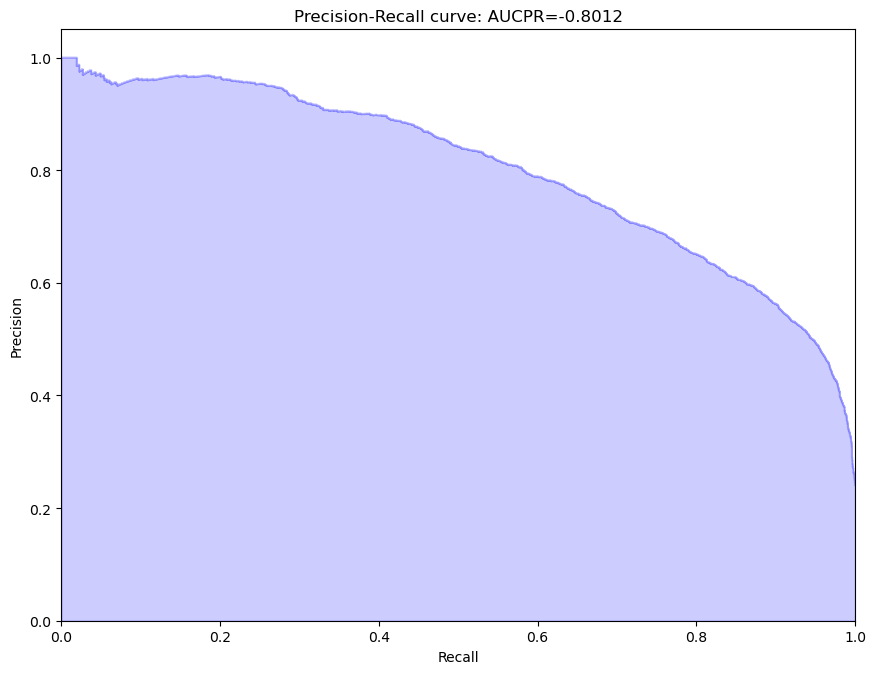

In [51]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

y_true = result["Target"].astype(int).values
y_score = result["P1"].values

precision, recall, thresholds = precision_recall_curve(y_true, y_score)
auc_pr = np.trapz(precision, recall)

plt.tight_layout()
plt.gcf().set_size_inches(10.24, 7.68)
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: AUCPR={0:0.4f}'.format(auc_pr))
plt.show()